# A Comprehensive Simulation of A/B Testing at a Company Similar to AirBNB

This notebook features a comprehensive simulation, crafted by ex-AirBNB Senior Data Scientist, [Stephanie Pancoast](https://www.linkedin.com/in/stephaniepancoast/), focusing on the design and analysis of A/B tests in a work setting.

All hands-on case studies within this notebook were completed by [Alex Riggio](https://www.linkedin.com/in/alexriggio/) over a four-week period, under the guidance and expert instruction of Stephanie Pancoast.

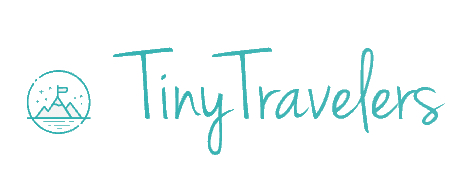

## Table of Contents
0. [Setup](#SETUP)
1. [Section 1: The Basics of A/B Testing](#SECTION-1:-BASIC-A/B-TESTING)
   - [Identify Target and Guardrails](#Task-1:-Identify-the-target-and-guardrail-metrics)
   - [A/B Test: Auto-Generate Title Feature](#Task-2:-Design-and-analyze-a-test!-Auto-generate-title.)
   - [A/B Test: Help Chat Feature](#Task-3:-Design-and-analyze-a-test!-Help-chat.)
   - [SUTVA](#Bonus-1:-SUTVA)
   - [A/B Test: Text to Clicker](#Task-4:-Design-and-analyze-another-test!-Free-text-to-clicker.)
2. [Section 2: Gotchas - How Things Can Go Awry](#SECTION-2:-Gotchas---How-things-can-go-awry.)
   - [A/B Test: Default Calendar Feature](#Task-1:-Design-and-analyze-a-test!-Default-open-calendar.)
   - [A/B Test: Email Reminder Feature](#Task-2:-Email-to-upload-photos)
   - [A/B Test: Mapping Feature](#Task-3:-New-map-service-for-Africa)
   - [A/B Test: Two Page Feature](#Task-4:-Break-out-into-two-pages)
3. [Section 3: Early Results - How to Check Safely](#SECTION-3:-Early-Results---How-to-Check-Safely)
   - [A/B Test: Landing Page Feature](#Task-1:-Landing-page-change)
   - [Recommended Pricing Bug](#Task-2:-Recommended-Price)
   - [A/B Test: Recommended Pricing Feature](#Task-3:-Recommended-Price-v2)
4. [Section 4: Concurrent Tests](#SECTION-4:-Concurrent-Tests)
   - [Possible Approaches](#Task-1:-Two-changes.-One-page.-What-should-we-do?)
   - [A/B Test: Orthogonal Approach](#Task-2.-Test-one-way)
   - [A/B Test: Split Traffic Aproach](#Task-3.-Alternate-reality)

## SETUP

Import libraries

In [20]:
# Import libraries
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
from IPython.display import Image

Define functions to:
- get the 95% confidence intervals
- calcuate the effect of the treatment
- perform a chi-squared test
- build a dataframe housing all the results

A standard two-sided t-test with the assumption of unequal variances (Welch's t-test) is used to compute the p-value.

In [21]:
def get_ci(mean_treatment, mean_control, n_treatment, n_control, dof, ci=0.95):
    """
    Calculates the confidence interval for the difference between two proportions (mean_treatment and mean_control),
    using a t-test.

    Parameters:
    mean_treatment (float): The mean (or proportion) of the treatment group.
    mean_control (float): The mean (or proportion) of the control group.
    n_treatment (int): The sample size of the treatment group.
    n_control (int): The sample size of the control group.
    dof (int): The degrees of freedom for the t-test.
    ci (float, optional): The confidence level for the interval (default is 0.95 for 95% confidence interval).

    Returns:
    tuple: A tuple containing the lower and upper bounds of the confidence interval.
    """

    # Calculate the standard deviation for the difference between two independent proportions
    sd = ((mean_treatment * (1 - mean_treatment)) / n_treatment + (mean_control * (1 - mean_control)) / n_control)**0.5

    # Calculate the difference in means (lift) between the treatment and control groups
    lift = mean_treatment - mean_control

    # Determine the critical score
    critical_score = stats.t.isf((1 - ci) / 2, dof)

    # Calculate the lower bound of the confidence interval
    lwr_bnd = lift - critical_score * sd

    # Calculate the upper bound of the confidence interval
    upr_bnd = lift + critical_score * sd

    # Return the lower and upper bounds of the confidence interval
    return lwr_bnd, upr_bnd


def calculate_results(df, metric, ci=0.95):
    """
    Calculates relative difference, absolute difference, p-value, and confidence intervals for specified metrics 
    from an A/B testing dataset.

    Parameters:
    df (DataFrame): The dataset containing A/B testing data.
    metric (str): The metric to analyze (must be one of 'new_active_listing', 'new_booked_listing', 
                  'new_cancelled_listing').
    ci (float, optional): The confidence level for the interval (default is 0.95 for 95% confidence interval).

    Returns:
    tuple: A tuple containing relative difference, absolute difference, p-value, and lower and upper bounds 
           of the confidence interval (adjusted for control mean).
    """

    # Validate metric
    if metric not in ('new_active_listing', 'new_booked_listing', 'new_cancelled_listing'):
        raise Exception("Invalid metric")

    # Compute mean values for both treatment and control groups
    mean_control = df.loc[df['variant'] == "control", metric].mean()
    mean_treatment = df.loc[df['variant'] == "treatment", metric].mean()

    # Calculate absolute and relative differences
    abs_diff = mean_treatment - mean_control
    rel_diff = (mean_treatment - mean_control) / mean_control

    # Perform two-sided t-test and get p-value
    data_group_control = list(df.query('variant == "control"')[metric])
    data_group_treatment = list(df.query('variant == "treatment"')[metric])
    results = stats.ttest_ind(a=data_group_control, b=data_group_treatment, equal_var=False)
    pvalue = results.pvalue

    # Calculate sample variances and sizes for t-test
    var1 = np.var(data_group_control, ddof=1)
    var2 = np.var(data_group_treatment, ddof=1)
    n1 = len(data_group_control)
    n2 = len(data_group_treatment)

    # Calculate degrees of freedom using the Welch-Satterthwaite Equation
    dof = ((var1/n1 + var2/n2)**2) / ((var1/n1)**2 / (n1 - 1) + (var2/n2)**2 / (n2 - 1))

    # Calculate 95% confidence intervals
    ci_low, ci_high = get_ci(
        mean_treatment=mean_treatment,
        mean_control=mean_control,
        n_treatment=n2,
        n_control=n1, 
        dof=dof,
        ci=ci,
    )

    # Adjust confidence intervals relative to control mean
    ci_low = ci_low / mean_control
    ci_high = ci_high / mean_control

    # Return calculated metrics
    return rel_diff, abs_diff, pvalue, ci_low, ci_high


def chi_squared_test(observed_frequencies):
    """
    Performs a chi-squared test on the observed frequencies.

    Parameters:
    observed_frequencies (array-like): An array of observed frequencies. 
        For an A/B test, this typically includes the count of samples in each group 
        (e.g., control and treatment).

    Returns:
    tuple: A tuple containing the chi-squared statistic and the p-value of the test.
    """
    chi_stat, p_value = stats.chisquare(observed_frequencies)
    return chi_stat, p_value


def build_results_dataframe(data_frame, metrics, features=None, chi=False, ci=0.95):
    """
    Constructs a DataFrame summarizing the results of A/B testing analysis. 

    Parameters:
    data_frame (DataFrame): The dataset containing A/B testing data.
    metrics (list): A list of target and guardrail metrics to analyze (e.g., new_booked_listing, new_canceled_listings).
    features (list, optional): A list of features to segment the data on. If None, no segmentation is done.
    chi (bool, optional): If True, performs a chi-squared test and includes the results. Default is False.
    ci (float, optional): The confidence level for interval calculations. Default is 0.95 (95%).

    Returns:
    DataFrame: A pandas DataFrame with the analysis results, including relative difference, absolute difference,
               p-values, confidence intervals, and optionally chi-squared test results.
    """
    
    results_dict = {} 
    
    # Case 1: No specific features for segmentation
    if not features:
        # Use the entire dataset for analysis
        df = data_frame

        # Perform chi-squared test if specified
        if chi:
            # Calculate sample sizes for control and treatment groups
            sample_size_control = df.query("variant == 'control'").shape[0]
            sample_size_treatment = df.query("variant == 'treatment'").shape[0]

            # Observed frequencies for chi-squared test
            observed_freq = np.array([sample_size_control, sample_size_treatment])

            # Conduct chi-squared test
            chi_stat, chi_p_value = chi_squared_test(observed_freq)

        # Iterate over each metric in the metrics list
        for metric in metrics:
            # Conduct A/B test on the metric
            rel_diff, abs_diff, pvalue, ci_low, ci_high = calculate_results(
                df=df,
                metric=metric,
                ci=ci,
            )

            # Store the results in the dictionary
            results_dict[(metric)] = {
                'rel_diff': f'{round(rel_diff * 100, 2)}%',
                'abs_diff': round(abs_diff * 100, 2),
                'p': round(pvalue, 4),
                'ci_lo': f'{round(ci_low * 100, 2)}%',
                'ci_hi': f'{round(ci_high * 100, 2)}%'
            }

            # Add chi-squared test results if applicable
            if chi:
                results_dict[(metric)]['ctrl_size'] = sample_size_control
                results_dict[(metric)]['trt_size'] = sample_size_treatment
                results_dict[(metric)]['chi_sq_p'] = round(chi_p_value, 4)

    # Case 2: Specific features are provided for segmentation
    else:
        # Iterate over each feature for segmentation        
        for feature in features:
            # Handle special case if the entire dataset is to be considered
            if feature != 'full_dataset':
                segments = data_frame[feature].unique().tolist()
            else:
                segments = ['full_dataset']
                df = data_frame
            for segment in segments:
                # Segment the data if not analyzing the full dataset
                if segment != 'full_dataset':
                    # Prepare query string for segment selection
                    query = f"{feature} == {repr(segment)}"
                    df = data_frame.query(query)
                # Perform chi-squared test if specified
                if chi:
                    # Calculate sample sizes for control and treatment groups
                    sample_size_control = df.query("variant == 'control'").shape[0]
                    sample_size_treatment = df.query("variant == 'treatment'").shape[0]
                    
                    # Observed frequencies for chi-squared test
                    observed_freq = np.array([sample_size_control, sample_size_treatment])
                    
                    # Conduct chi-squared test
                    chi_stat, chi_p_value = chi_squared_test(observed_freq)

                # Iterate over each metric in the metrics list
                for metric in metrics:
                    # Conduct A/B test on the metric
                    rel_diff, abs_diff, pvalue, ci_low, ci_high = calculate_results(
                        df=df,
                        metric=metric,
                        ci=ci,
                    )
                    
                    # Initialize sub-dictionary 
                    results_dict[(feature, segment, metric)] = {}
                    
                    # Store the results in the sub-dictionary for the segmented data
                    results_dict[(feature, segment, metric)]['rel_diff'] = f'{round(rel_diff * 100, 2)}%'
                    results_dict[(feature, segment, metric)]['abs_diff'] = round(abs_diff * 100, 2)
                    results_dict[(feature, segment, metric)]['p'] = round(pvalue, 4)
                    results_dict[(feature, segment, metric)]['ci_lo'] = f'{round(ci_low * 100, 2)}%'
                    results_dict[(feature, segment, metric)]['ci_hi']= f'{round(ci_high * 100, 2)}%'
                    
                    # Add chi-squared test results if applicable
                    if chi:
                        results_dict[(feature, segment, metric)]['ctrl_size'] = sample_size_control
                        results_dict[(feature, segment, metric)]['trt_size'] = sample_size_treatment
                        results_dict[(feature, segment, metric)]['chi_sq_p']= round(chi_p_value, 4)
    
    # Convert the results dictionary to a DataFrame    
    df_results = pd.DataFrame.from_dict(results_dict, orient='index')
    
    # Convert columns to float
    df_results['p'] = df_results['p'].astype(float)
    if chi:
        df_results['chi_sq_p'] = df_results['chi_sq_p'].astype(float)
    
    
    # Define the styling function
    def highlight_p_values(val, chi=False):
        """
        Highlights cells in green if the value is <= 0.05.
        """
        color = 'green' if val <= 0.05 else ''
        return f'background-color: {color}'

    # Apply the styling function to the DataFrame
    highlight_subset = ['p', 'chi_sq_p'] if chi else ['p']
        
    df_results_styled = df_results \
        .style \
        .map(highlight_p_values, subset=highlight_subset) \
        .format({'abs_diff':'{:.3f}', 'p': '{:.4f}', 'chi_sq_p': '{:.4f}'})
    
    return df_results_styled

# SECTION 1: Basic A/B Testing

## Background
Welcome to **TinyTravelers**! We are essentially Airbnb for families with young kids. You recently joined as a product data scientist on a team focused on growing the number of homes on the platform. They are currently focused on improving the onboarding flow and have some ideas for improvements, but they need your help!

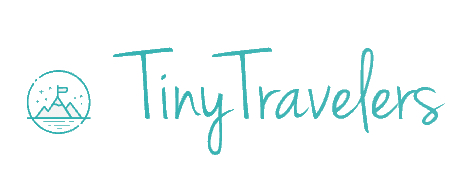

## Task 1: Identify the target and guardrail metrics

Since your team is focused on activation for hosts and are working in the onboarding flow, the new host user journey is the most relevant to your metric selection decision. The table below contains details about key steps in the journey, the percent that make it from one step to another, and how long it roughly takes for those who do make it. For now you can assume each host only has one home (aka listing).

| **User journey step**                | **Conversion rate from last step** | **Conversion rate from start** | **Median time since last step** |
|--------------------------------------|------------------------------------|--------------------------------|---------------------------------|
| Start onboarding flow                | N/A                                | N/A                            | N/A                             |
| Publish home / finish onboarding flow| 40%                                | 40%                            | 2 hours                         |
| Home is booked by a guest            | 50%                                | 20%                            | 7 days                          |
| First guest stays at their home      | 90%                                | 18%                            | 14 days                         |
| Home receives its first review       | 60%                                | 10.8%                          | 2 days                          |

### Task 1.a. Pros and cons of potential metrics

Identify and list the advantages and disadvantages of various key metrics that could effectively measure the impact of modifications in the user onboarding process.

_______________________________________________
_______________________________________________
**ANSWER**

New active listings:

- Pros:

  - High Sensivity: Early stages in the onboarding flow have higher conversion rates, allowing for the detection of changes with a smaller sample size.
  - High Timeliness: This metric has the shortest median lag time ensuring quick measurement and analysis.

- Cons:

  - Low Business Connection: The activity of generating new listings is relatively distant from the crucial business outcome of guests leaving reviews.

New booked listings:   

- Pros:
  - Balanced Approach: Offers a moderate level of sensitivity and timeliness, coupled with a reasonable degree of relevance to core business objectives.
  - Holistic: Begins to address both the supply and demand aspects of the marketplace as it requires action (conversion) from the host and the guest.

- Cons:
  - Lack of Specialization: A balanced approach may result in a metric that does not cater to any particular aspect, which could be significant depending on the specific needs of management.

New reviewed listings:

- Pros:

  - High Business Connection: A home receiving a review is considered the most meaningful activity for the business because it signals guest satisfaction, impacts future bookings, informs hosts on how to improve, and signifies the completion of a full transaction cycle. 
  - Holistic: Addresses both the supply and demand aspects of the marketplace.

- Cons:

  - Low Sensitivity: The conversions rates are the lowest for this step of the onboarding flow.
  - Low Timeliness: The median time for a home to receive a review in the onboarding flow is over two weeks.
  - Because of these two cons it will require much more time to conduct the A/B test with suitable power.
_______________________________________________
_______________________________________________

### Task 1.b. Justify the choice of one metric

_______________________________________________
_______________________________________________
**ANSWER**

New Booked Listings:

- New booked listings seem like the most practical choice, striking a balance between sensitivity, timeliness, and relevance to our core business objectives. In an ideal world, without constraints, new reviewed listings would be the best approach. In contrast, under stricter deadlines and with a higher tolerance for risk, new active listings would be preferrable.
_______________________________________________
_______________________________________________

### Task 1.c. List possible guardrail metrics

Guardrail metrics are the measurements we want to track to ensure that the change is not having unintended consequences. 

List a few possible guardrail metrics.

_______________________________________________
_______________________________________________
**ANSWER**

Duration Spent on Each Step: 

- An excessive amount of time spent on creating a listing might suggest confusion or difficulty with the platform. Similarly, a prolonged duration for a listing to get booked could be indicative of the listing's low quality or poor market fit.

Average Review Score: 

- A decline in this metric could signal a mismatch between guest expectations and their actual experiences. This discrepancy might originate from unclear instructions or low-quality listings, both of which would need to be addressed.
_______________________________________________
_______________________________________________

## Task 2: Design and analyze a test! Auto-generate title.

After a discussion with your manager, PaM, it was decided to use new booked listings (NBL) for the target metric and cancellations as the guardrail. We will also be monitoring new active listings (NAL) to understand the impact on the funnel, but the impact on the metric won't matter for the decision to launch or not.

The team is now ready to start measuring the impact of their ideas!

One page of the onboarding (publish) flow is to create the title for the listing. The title of a listing shows up in search when guests are looking for a place to stay, so it's important. But the team knows a lot of people get stuck here and abort the flow. So they came up with an idea to make it easier... enter ChatGPT! Instead of asking a host to come up with their own title, a default title will be auto-generated, leveraging the information already known about the home (e.g. location, amentities). The specific design change is below.

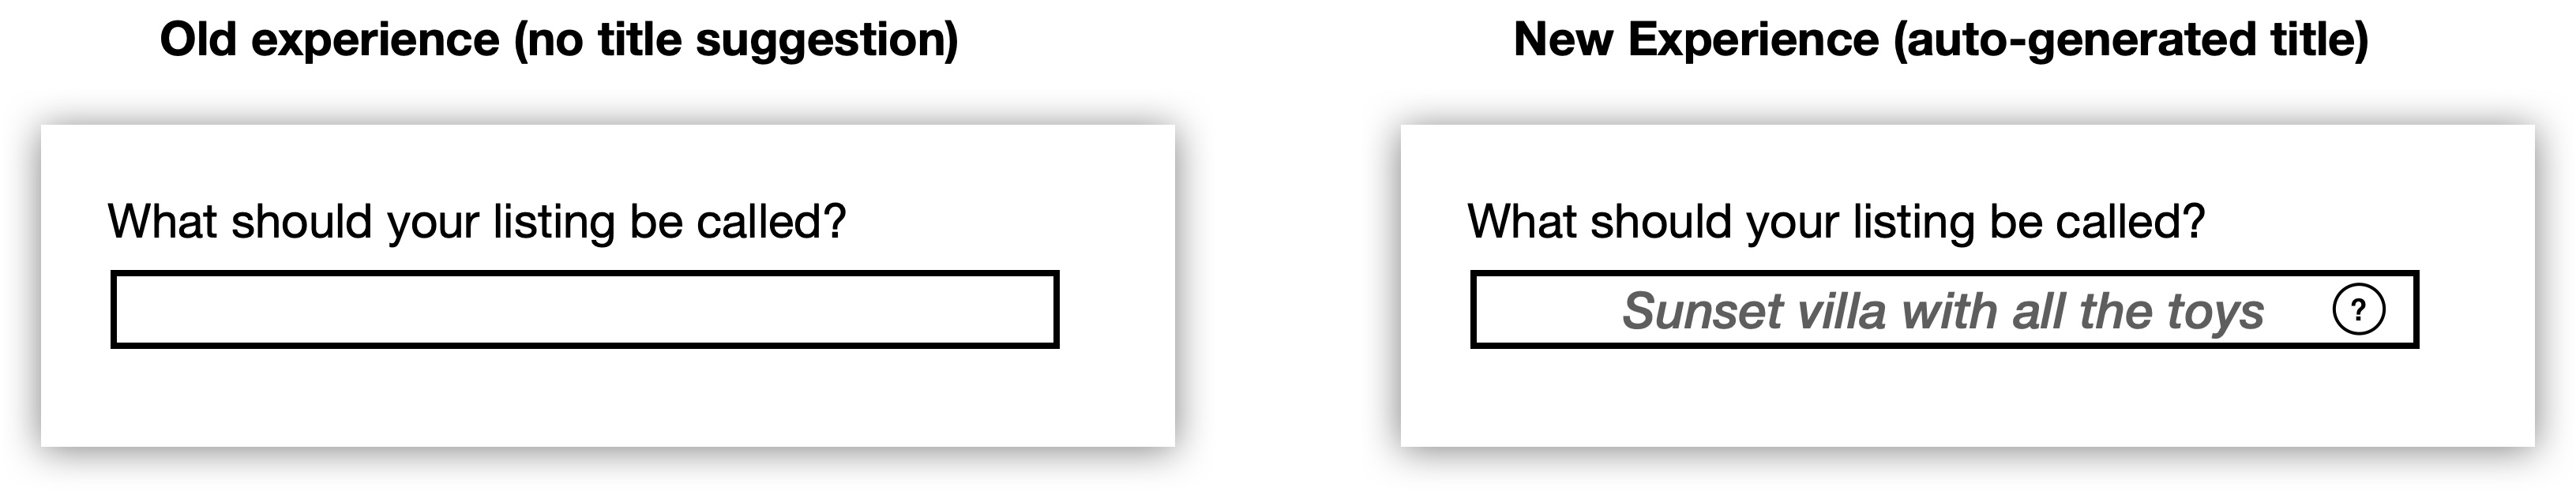

Due to the technical complexity of integrating with ChatGPT, we would need to see at least a _5% relative increase_ for this to be practically significant. Any smaller impact, even if positive, would not be worth it and we would choose not to launch.

### Task 2.a. Test design by answering the following...

#### Task 2.a.i. When should the test be triggered?

_______________________________________________
_______________________________________________
**ANSWER**

Ideally the test should be triggered as close as possible to the rendering of the title naming. In practice, this will need to be decided in conjuction with the engineers to what is feasible. For the sake of this example we can choose to trigger the test when the host clicks the "next" button that takes them to the page to choose the title.
_______________________________________________
_______________________________________________

#### Task 2.a.ii. What is the hypothesis?

_______________________________________________
_______________________________________________
**ANSWER**

If we provide a ChatGPT suggestion, it will increase new booked listings, because better titles are expected to garner more views and ultimately lead to more bookings.
_______________________________________________
_______________________________________________

#### Task 2.a.iii. How long should the test run and how will the launch / no launch decision be made?

You can assume _5k_ new people hit the triggering point each day. Remember PaM had determined that she only cares about 5% or more impact. 

Use Evan Miller's [sample size calculator](https://www.evanmiller.org/ab-testing/sample-size.html) to do the power analysis.

_______________________________________________
_______________________________________________
**ANSWER**

Based on the sample size calculator, to detect a 5% relative increase with an assumed 20% conversion rate, we need 25,255 samples in each group, totaling 50,510 samples. Given that we acquire 5,000 samples daily, it will initially take 11 days to gather the required number. However, to ensure a balanced representation of all days of the week (account for seasonality), we will extend this period to 14 days. Additionally, to allow each sample sufficient time to complete its journey, we'll add another 7 days. This brings our total collection period to 21 days, or three weeks.
_______________________________________________
_______________________________________________

### Task 2.b. Test analysis

The results from our A/B test are in!!! Time to open the box and see what happened. Please analyze the test and summarize the learnings and recommendations for PaM and the team below with the data provided in `autotile.csv`.

_Basic_: What happened at a high-level to the target (new booked listings) and guardrail (new cancelled listings) metrics? Do you recommend the team launch the change or not based on the results you observe?

_Bonus_: Dig further to understand if the change was driven entirely by improving conversion through the onboarding flow without changing appeal (aka any change detected for new booked listing was entirely driven by a lift in new active listings) or might the bookability/ appeal change as well?

In [22]:
# Read the CSV file into a dataframe
df_autotitle = pd.read_csv('data/autotitle.csv')

# Run the A/B test
df_results = build_results_dataframe(
    data_frame=df_autotitle, 
    metrics = ['new_active_listing','new_booked_listing','new_cancelled_listing'],
    ci=0.95,
)

# Display the results
display(df_results)

,rel_diff,abs_diff,p,ci_lo,ci_hi
new_active_listing,9.77%,3.920,0.0000,7.89%,11.65%
new_booked_listing,7.77%,1.130,0.0001,4.0%,11.53%
new_cancelled_listing,2.79%,0.020,0.7831,-17.05%,22.62%


What happened at a high-level to the target (new booked listings) and guardrail (new cancelled listings) metrics? Do you recommend the team launch the change or not based on the results you observe?

_______________________________________________
_______________________________________________
**ANSWER**

Target Metric:

- We see that the treatment group's conversion rate for new booked listings is 7.8% higher relative to the control group.

- The p value is close to zero so there is little doubt that the observed difference is statistically significant.

- Likewise, the non-zero positive confidence interval indicates that the treatment group has a higher conversion rate. We are 95% confident that the true relative conversion rate for the treatment group is somwhere between 4% to 11.5% higher than the control group.


Guardrail Metric:

- We see that the treatment group's conversion rate for new canceled listings is 2.8% higher relative to the control group.

- The p value is well over 0.05 so it is likley that the observed difference is NOT statistically significant.

- Likewise, the value 0 falls within the confidence interval and indicates that the conversion rate is the same between the two groups. We are 95% confident that the true relative conversion rate for the treatment group is somewhere between -17% to 23% different than the control group.


Conclusion:

- The results of our target metric are in favor of launching the change. It is very likley that the change has increased the conversion rate of new booked listings, and relaxing the confidence interval to 85% yields a lower bound of a 5%, which is the minimum relative increase that management deemed worthwhile.

- In addition, the guardrail metric was not negatively impacted by the change, so we are good to go.

_______________________________________________
_______________________________________________

### What happened?

You brought your findings to PaM and the team and they were SO excited to see the impact of this change. It is clearly indicated that suggesting a title helped some stuck hosts-to-be get unstuck and the impact was well worth the cost of the technical integration. The change was launched to 100% with a pop of chatGPT champagne.

## Task 3: Design and analyze a test! Help chat.

The team wants to try having a support person available during the onboarding flow, with the hypothesis that it will give people the confidence they need to publish their home. The way they are implementing this is with a "painted door". Every host will have a "\(?\)" in the bottom left corner of every page of the flow. However, only 50% will be connected to a support person, with the other 50% being given a prompt around how no one is available. You can see the design and flow in the image below. It's not an ideal experience for the hosts, but it's temporary and we really want to isolate the impact of a help center.

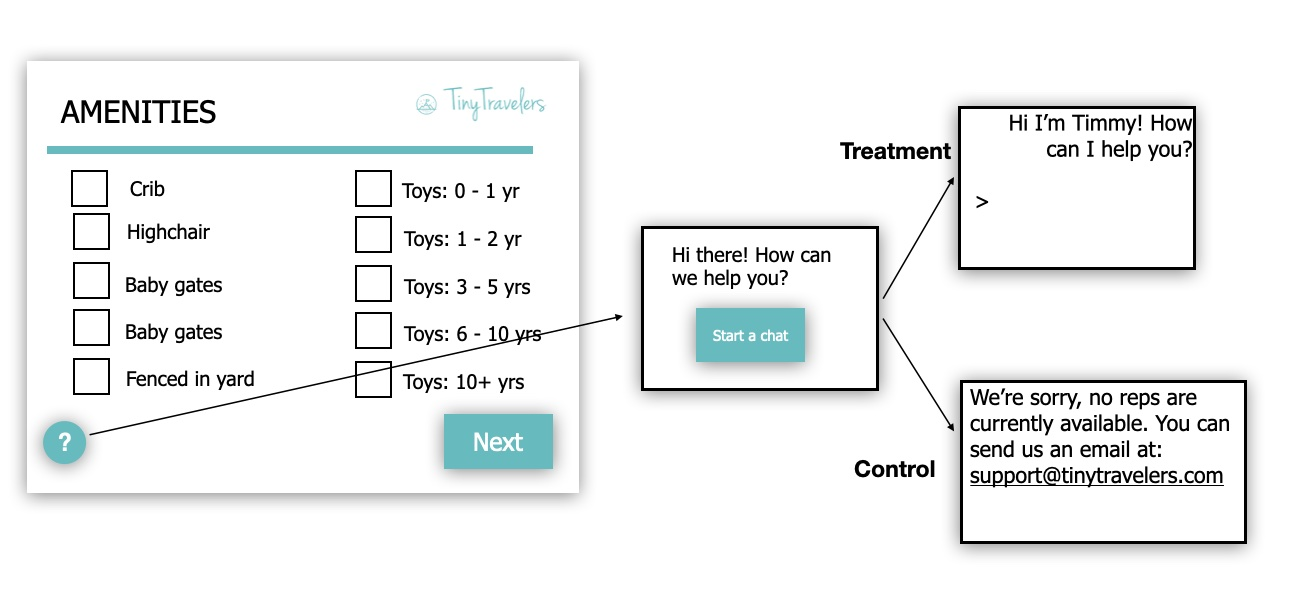

The test is triggered upon someone hitting the "\(?\)" button. 

The hypothesis is: If we connect a host looking for help with a human, NBL will increase because the host will have confidence (driving NAL), therefore also driving NBL.

If we go forward with this change, it'll be expensive. So PaM is looking for a big change here. She would only want to ship if the change is 8% or higher. At the same time, she does care about detecting meaningful changes and wants to make sure changes of 15% or greater on NBL are not missed. This is fortunate because we're in small(ish) data land.

You previously put the defunct painted door ("\(?\)" -> no one is available) in the onboarding flow in for a week, to check that it didn't majorly impact on NAL on it's own (it didn't) and to get an estimate of the volume. Turns out, you only have 250 people clicking that button each day. Their base conversion rates are lower than average too, with only 30% receiving an NAL and 10% receiving an NBL (start to publish = 30%, start to first booking = 10%).

### Task 3.a. Test design: How long should the test run and how will the launch/ no launch decision be made?

As mentioned above, only 250 people click the botton each day (that's the number of new users per day in your test). The conversion rate is 10%. Remember PaM had determined that she would not want to miss a 15% lift. Use Evan Miller's [sample size calculator](https://www.evanmiller.org/ab-testing/sample-size.html) to do the power analysis.

_______________________________________________
_______________________________________________
**ANSWER**

Standard Approch:

- Based on the sample size calculator, using new booked listings as our target metric with a 10% conversion rate and a 15% minimum detectable effect, we will require 6,401 samples per group. This amounts to a total of 12,802 samples. At a rate of 250 samples per day, it will take 52 days to collect the necessary data. Adding an additional 4 days to account for weekly seasonality, and 7 more days for all samples to complete their cycle, the total duration needed is 63 days.

- If this timeframe is impractical, we have two alternatives with shorter runtimes.

Alternative 1:

- We could reduce the statistical power from 80% to 70%, which would require 5,005 samples per group, totaling 10,010 samples. This adjustment would reduce the collection period to 41 days. A total of 49 days would be needed after accounting for seasonality and cycle completion. 

- However, this approach is risky, as we would fail to detect a 15% relative effect almost one-third of the time.

Alternative 2:

- Another option is to target new active listings, under the assumption that an increase in new active listings will lead to more new booked listings. This correlation was observed in our previous A/B tests with ChatGPT-generated titles. If we set new active listings as our metric, with a 30% conversion rate and a 15% minimum detectable effect, each group would need 1,646 samples, totaling 3,292 samples. We could gather this amount in 14 days. To allow all samples to complete their cycle, we would extend the period to 21 days.
_______________________________________________
_______________________________________________

### Task 3.b. Test analysis

After talking with PaM, you decided to run the test for 56 days at 50/50, and keep the p-value threshold at 0.05. Because employing humans to answer questions is expensive, you really want to be confident that the experience is positive. PaM wants to be as confident as possible that if we call something SS it's not due to noise, and that the quality bar of any incremental listings is maintained.

After a long waiting period, the results are finally in!!! Please analyze the test and summarize the learnings and recommendations for PaM and the team below with the A/B test data provided.

In [23]:
# Read the CSV file into a dataframe
df_help_center = pd.read_csv('data/help_center.csv')

# Run the A/B test
df_results = build_results_dataframe(
    data_frame=df_help_center, 
    metrics = ['new_active_listing','new_booked_listing','new_cancelled_listing'],
    ci=0.95,
)

# Display the results
display(df_results)

,rel_diff,abs_diff,p,ci_lo,ci_hi
new_active_listing,5.49%,1.620,0.0367,0.34%,10.65%
new_booked_listing,9.86%,0.920,0.0679,-0.72%,20.44%
new_cancelled_listing,32.32%,0.140,0.2467,-22.36%,87.01%


What happened at a high-level to the target (new booked listings) and guardrail (new cancelled listings) metrics? Do you recommend the team launch the change or not based on the results you observe?

_______________________________________________
_______________________________________________
**ANSWER**

Target Metric - New Booked Listings:

- We see that the treatment group's conversion rate for new booked listings is 9.9% higher relative to the control group.

- The p value is greater than 0.05 so the observed difference is considered NOT statistically significant.

- Likewise, the value 0 falls within the confidence interval and indicates that the conversion rate is the same between the two groups. We are 95% confident that the true relative conversion rate for the treatment group is somewhere between -0.7% to 20.4% different than the control group.


Guardrail Metric - New Canceled Listings:

- We see that the treatment group's conversion rate for new canceled listings is 32.3% higher relative to the control group.

- The p value is well over 0.05 so it is likley that the observed difference is NOT statistically significant.

- Likewise, the value 0 falls within the confidence interval and indicates that the conversion rate is the same between the two groups. We are 95% confident that the true relative conversion rate for the treatment group is somewhere between -22.4% to 87% different than the control group.

Conclusion:

- Introducing human customer support does not seem to negatively impact new booked listings or cancelation rates. However, it is costly to implement and PaM was seeking a notable positive effect of at least 8% to new booked listings. The absence of a statistically significant effect leads us to advise against proceeding with this change.

- It is worth noting, that our sample sizes were calibrated to detect, with 80% statistical power, only changes as large as 15 percent. More subtle increases may have been overlooked. Extending the testing duration might reveal smaller effects.
_______________________________________________
_______________________________________________

## Bonus 1: SUTVA

### Bonus 1.a. How might A/B testing in the onboarding flow violate SUTVA?

As a reminder, SUTVA implies that:
1. The treatment (or intervention) of one unit (e.g., a user in an A/B test) does not affect the outcome of another unit.
2. The treatment is applied in a consistent manner across units.

_______________________________________________
_______________________________________________
**ANSWER**

Members of the treatment group, having been assisted by human support and ChatGPT during the onboarding process, might share their experiences. As a result, members of the control group may develop an expectation for similar assistance and, upon not receiving such support, become more quickly discouraged.
_______________________________________________
_______________________________________________

## Task 4: Design and analyze another test! Free text to clicker.

One step in the onboarding flow is to change the guest details UI. The team believes that having a default and clicking to adjust the amounts will be less friction than typing.

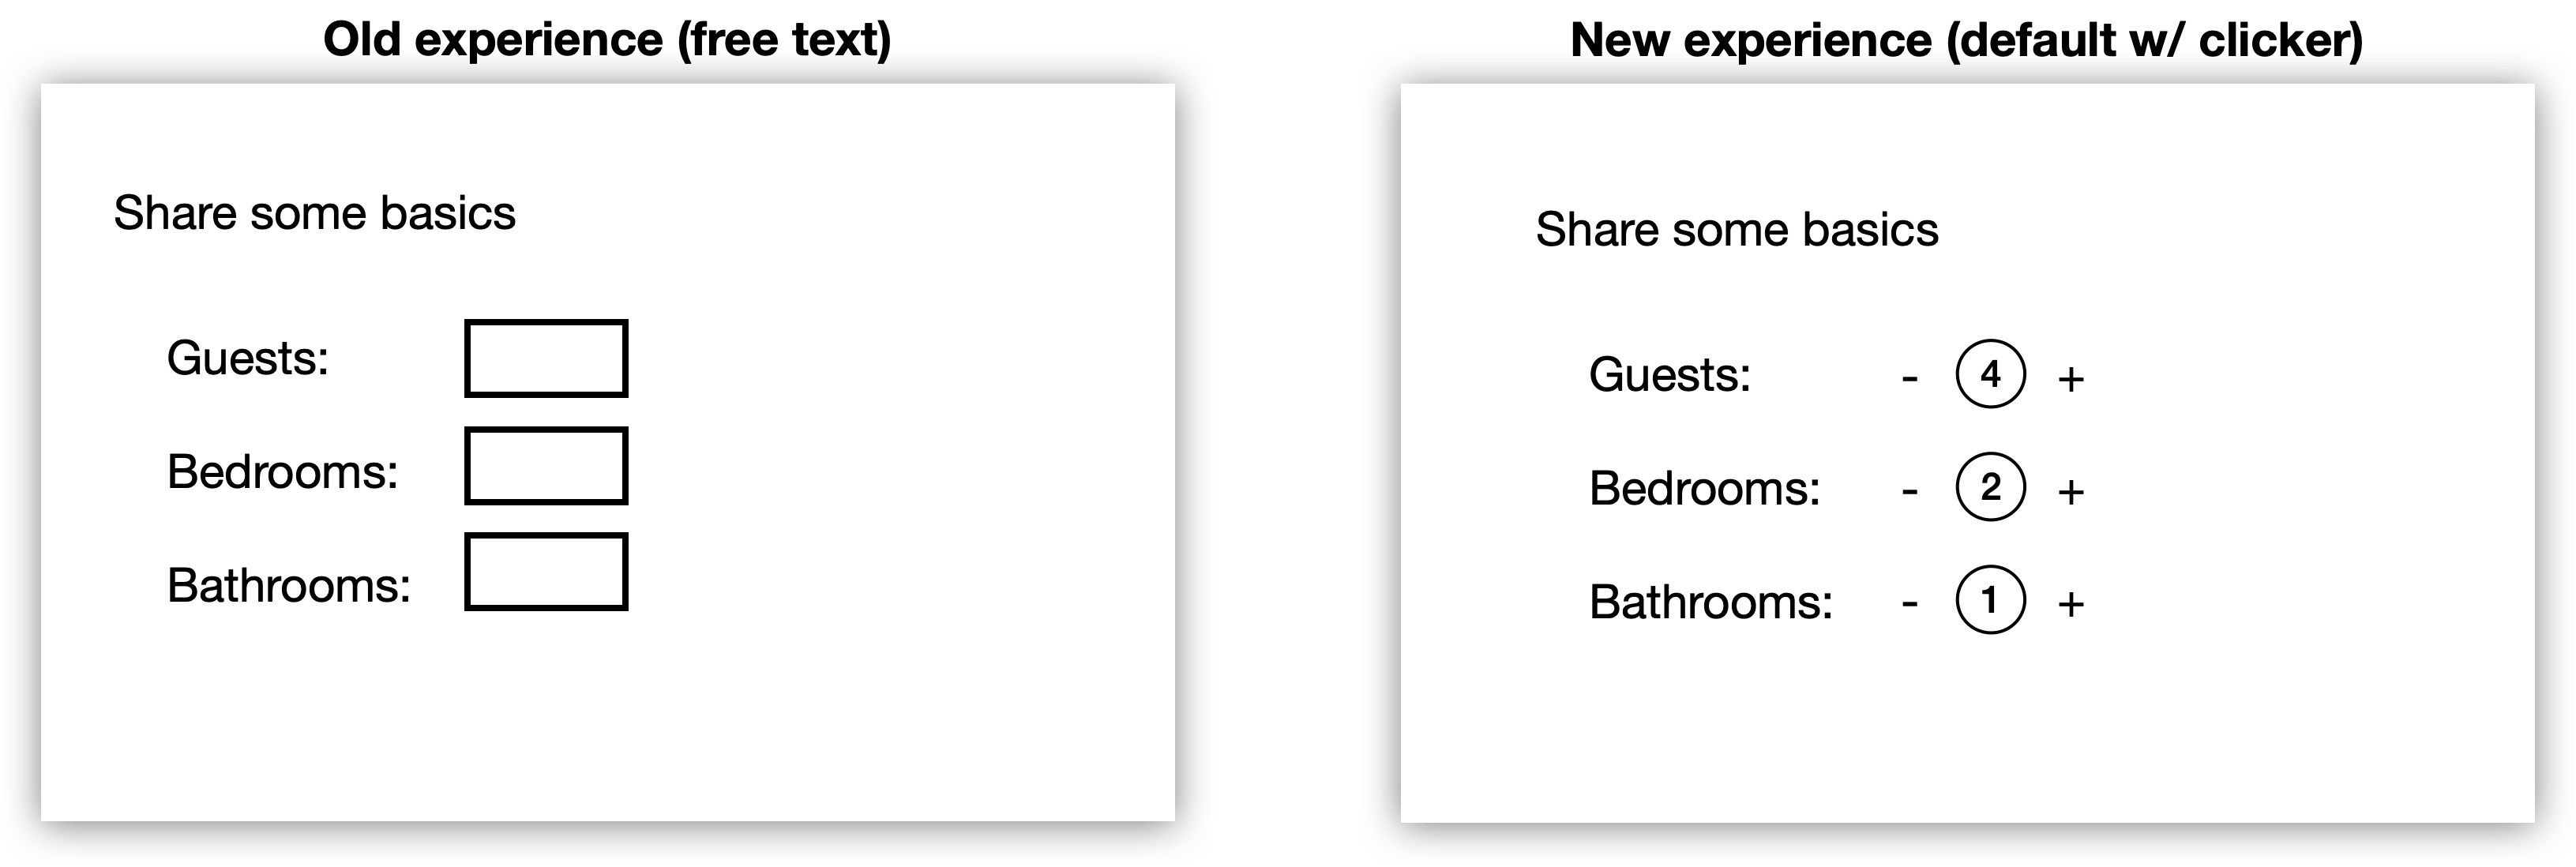

The hypothsis for this is change is: "If we change the free text field on the basics page to a clicker it will increase new booked listings because it will reduce the friction to publish a listing."

#### Task 4.a. How long should the test run and how will the launch/ no launch decision be made?

In this case PaM does care about detecting smaller changes and wants to be in position to capture a _2% relative increase_ if it exists. This change isn't blocking other planned work, so she is OK if we need to run it for up to 8 weeks. Of course, if we can detect a 2% change in fewer than 8 weeks that would be great. Fortunately there are more visitors to this page at the time this test is run, so you can assume _10K_ hit the triggering point each day.

_______________________________________________
_______________________________________________
**ANSWER**

According to the sample size calculator, each group will need to have 58,923 samples. With a total of 117,846 samples needed, if 10k samples are available each day, it will take 12 days to achieve this outcome.
_______________________________________________
_______________________________________________

### Task 4.b. Test analysis

Please analyze the test and summarize the learnings and recommendations for PaM and the team below. The datat has already been cleaned for you.

What happened at a high-level to the target (new booked listings) and guardrail (new cancelled listings) metrics, and do you recommend a launch or not based on that?

In [24]:
# Read the CSV file into a dataframe
df_text_to_clicker = pd.read_csv('data/text_to_clicker.csv')

# Run the A/B test
df_results = build_results_dataframe(
    data_frame=df_text_to_clicker, 
    metrics = ['new_active_listing','new_booked_listing','new_cancelled_listing'],
    ci=0.95,
)

# Display the results
display(df_results)

,rel_diff,abs_diff,p,ci_lo,ci_hi
new_active_listing,0.16%,0.070,0.7070,-0.69%,1.02%
new_booked_listing,0.18%,0.010,0.8778,-2.13%,2.49%
new_cancelled_listing,3.0%,0.010,0.6713,-10.85%,16.85%


_______________________________________________
_______________________________________________
**ANSWER**

Target Metric - New Booked Listings:

- We see that the treatment group's conversion rate for new booked listings is 0.2% higher relative to the control group.

- The p value is well over 0.05 so the observed difference is considered NOT statistically significant.

- Likewise, the value 0 falls within the confidence interval and indicates that the conversion rate is the same between the two groups. We are 95% confident that the true relative conversion rate for the treatment group is somewhere between -2.1% to 2.5% different than the control group.


Guardrail Metric - New Canceled Listings:

- We see that the treatment group's conversion rate for new canceled listings is 3% higher relative to the control group.

- The p value is well over 0.05 so it is likely that the observed difference is NOT statistically significant.

- Likewise, the value 0 falls within the confidence interval and indicates that the conversion rate is the same between the two groups. We are 95% confident that the true relative conversion rate for the treatment group is somewhere between -10.9% to 16.8% different than the control group.

Conclusion:

- Adding the clicker does not appear to adversely effect new booked listings or canceled listings. At the same time, there is no indication that it increases new booked listings the desired 2%. Therefore, it is not recommned to be implemented unless for some reason this aligns with some greater UI or strategic vision.
_______________________________________________
_______________________________________________

### What happened?

You brought the summary to PaM and the team. They were a bit disappointed their idea didn't pan out but understand not everything can work, and they were still happy from the auto-title change topped with champagne. So they rolled back the change and deleted the code supporting the clickers. Onward!

## Background

Welcome back to **TinyTravelers**, you extraordinary product data scientist! It’s been a few months, and you and your team are rolling now! Carrying over from the work you did last week- the team is sticking with new booked listings as the target metric, new cancelled listings as the guardrail, and new active listings as an informative metric.

This time, four A/B tests need to be designed and analyzed. There may be some surprising results, so be sure to analyze the results carefully! The test data is simulated, but that doesn't mean that we've simulated a flawless run of the test. If you're surprised by your results, think carefully about what could have caused them.

Note that for analysis, we are now providing some segmentation information about each user: continent, device, and if they have been a host on Tiny Travelers before. This information will be helpful for some of the tests but not all.

# SECTION 2: Gotchas - How things can go awry.

## Background

Welcome back to **TinyTravelers**, you extraordinary product data scientist! It’s been a few months, and you and your team are rolling now! Carrying over from the work you did last week- the team is sticking with new booked listings as the target metric, new cancelled listings as the guardrail, and new active listings as an informative metric.

This time, four A/B tests need to be designed and analyzed. There may be some surprising results, so be sure to analyze the results carefully! The test data is simulated, but that doesn't mean that we've simulated a flawless run of the test. If you're surprised by your results, think carefully about what could have caused them.

Note that for analysis, we are now providing some segmentation information about each user: continent, device, and if they have been a host on Tiny Travelers before. This information will be helpful for some of the tests but not all.

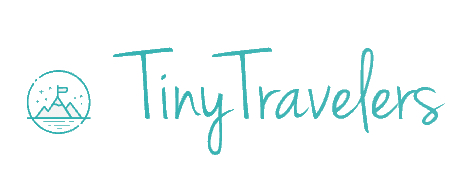

## Task 1: Design and analyze a test! Default open calendar.
Hosts start on TinyTravelers with an entirely blocked calendar. Meaning they need to toggle the dates to be bookable. The team hypothesizes that new booked listings can increase if they start with a default available calendar and toggle dates to block them instead.

The UI change is shown below.

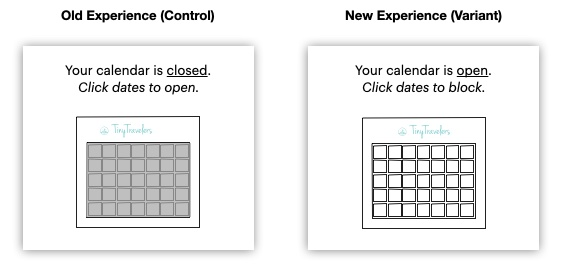

### Task 1.a. Test Design: How long should the test run and how will the launch / no launch decision be made?

You can assume that about 5K new users arrive in the flow each day. And the cohort to book rate is 25% because the cohorting happens later in the flow when only the higher intent people are still there. 

Triggering Moment: The test is triggered upon loading the calendar page. 

Remember, we're building on our work from [Section 1](#SECTION-1:-BASIC-A/B-TESTING), so don't be afraid to look back if it helps!

Now the question remains: How long should the test run and how will the decision be made?

_______________________________________________
_______________________________________________
**ANSWER**

HYPOTHESIS: 
- If we default to an available calendar in the onboarding flow, new booked listings will increase because hosts will finalize more active listings with more available booking dates.

ASSUMPTIONS:

| **User journey step**                | **Conversion rate from last step** | **Conversion rate from start** | **Median time since last step** |
|--------------------------------------|------------------------------------|--------------------------------|---------------------------------|
| Start onboarding flow                | N/A                                | N/A                            | N/A                             |
| Publish home / finish onboarding flow| ??%                                | ??%                            | 2 hours                         |
| Home is booked by a guest            | ??%                                | 25%                            | 7 days                          |

DESIRED MINIMUM DETECTABLE EFFECT: 
- 5%

ANSWER:

Given that 5k users pass through the trigger point daily, I suggest a 21-day runtime for the A/B test. In the initial 8 days, we will see a total of 40k users participate in the test. Dividing equally between control and treatment, this translates to 20k users per group. Samples of this size will enable us to detect a minimum relative effect of 5% with 80% statistical power, offering adequate sensitivity for our analysis. The following 6 days are to account for weekly seasonality, and the concluding 7 days are to allow users who began the process on the 14th day to finalize their cycle.

DURATION OF THE A/B TEST:
- 21 days

LAUNCH CRITERIA: 
- If the target significantly improves without substantial negative impact to the guardrail.
_______________________________________________
_______________________________________________

### Task 1.b. Test analysis

Please analyze the test and summarize the learnings and recommendations for PaM and the team below with the A/B test data provided.

There is information for three milestones:

* new_active_listing - 1 if a user published their listing during experiment. Otherwise 0.
* new_booked_listing - 1 if a user received a guest booked on a new listing during the experiment. Otherwise 0.
* new_cancelled_listing - 1 if a user cancelled a new booking during the experiment. Otherwise 0.

We also provided some segmentation information for each user.
* continent - the continent for the host, either 'asia','north_america','south_america','australia','europe','africa'
* booked_previously - 1 if the host has hosted before the started the onboarding flow (because they have a home on a different platform like Airbnb).
* device - the device the host is using when starting the onboarding flow. Either 'android', 'ios' or 'web'.

Note: Only use a user segment when you have a reason to do so.

In [25]:
# Read the CSV file into a dataframe
df_calendar = pd.read_csv('data/default_calendar.csv')

# Run the A/B test
df_results = build_results_dataframe(
    data_frame=df_calendar,
    metrics=['new_booked_listing','new_cancelled_listing'],
    features=['full_dataset', 'continent', 'booked_previously', 'device'],
    ci=0.95
)

# Display the results
display(df_results)

_______________________________________________
_______________________________________________
**ANSWER**

### FULL DATASET ANALYSIS

| **metric**            | **rel-diff** | **p-val** | **ci-lo** | **ci-hi** |
|-----------------------|-------------------------|--------------|------------|-------------|
| new_booked_listing    |          4.71%             | 0.0006       | 2.03%      | 7.4%      |
| new_cancelled_listing | 23.47%                  | 0.0010       | 9.44%     | 37.51%       |

**Target Metric: New Booked Listing**

- We see that the treatment group's conversion rate for new booked listings is 4.7% higher relative to the control group.

- The p value is close to zero so there is little doubt that the observed difference is statistically significant.

- Likewise, the non-zero positive confidence interval indicates that the treatment group has a higher conversion rate. We are 95% confident that the true relative conversion rate for the treatment group is somwhere between 2% to 7.4% higher than the control group.


**Guardrail Metric: New Cancelled Listing**

- We see that the treatment group's conversion rate for new canceled listings is 23.4% higher relative to the control group.

- The p value is well under 0.05 so it is likley that the observed difference is statistically significant.

- Likewise, the non-zero positive confidence interval indicates that the treatment group has a higher conversion rate. We are 95% confident that the true relative conversion rate for the treatment group is somwhere between 9.4% to 37.5% higher than the control group.


**Conclusion:**

The results of our analysis suggest that we should NOT implement the change of a default available calendar to the entire population. This is because, even though this change significantly increased conversion, at the same time it significantly increased booking cancelations.  

### SEGMENT ANALYSIS

Segment analysis has identified a few possible groups of interest where the calendar change had a significant positive effect on the target metric and did not have a significant negative effect on the guardrail metric.

1. **African Continent:** Recommend NOT to implement this change for now but can conduct further testing if economically justifiable.

| **metric**            | **rel-diff** | **p-val** | **ci-lo** | **ci-hi** |
|-----------------------|-------------------------|--------------|------------|-------------|
| new_booked_listing    |          11.58%             | 0.0138       | 2.37%      | 20.79%      |
| new_cancelled_listing | 44.29%                  | 0.0863       | -6.22%     | 94.8%       |

 - May have suffered from 'p-hacking'.
 - Relatively small sample sizes, ~4.7k.
 - Given the high relative increase in cancellations, the borderline non-significant p-value, and the wide confidence interval, a follow-up test focusing on the African segment would be necessary to understand this segment better.

2. **Previous Booking Experience:** Recommend to implement this change with continued monitoring as a precaution.

| **metric**            | **rel-diff** | **p-val** | **ci-lo** | **ci-hi** |
|-----------------------|-------------------------|--------------|------------|-------------|
| new_booked_listing    |          17.19%             | 0.0000       | 11.04%      | 23.33%      |
| new_cancelled_listing | 4.14%                  | 0.7931       | -26.79%     | 35.07%       |

 - Clear increase in new booked listings.
 - The increase in cancellations is not statistically significant, and given the wide confidence interval, it does not provide compelling evidence that the change causes more cancellations.

 3. **Android Device:** Recommend NOT to implement this change for now but can conduct further testing if economically justifiable.

| **metric**            | **rel-diff** | **p-val** | **ci-lo** | **ci-hi** |
|-----------------------|-------------------------|--------------|------------|-------------|
| new_booked_listing    |          5.81%             | 0.002       | 2.12%      | 9.5%      |
| new_cancelled_listing | 17.1%                  | 0.0699       | -1.39%     | 35.58%       |

 - May have suffered from 'p-hacking'.
 - Given the high relative increase in cancellations, the borderline non-significant p-value, and the wide/predominantly positive confidence interval, a follow-up test focusing on the Android Device segment would be necessary to understand this segment better.
_______________________________________________
_______________________________________________

### What happened?

You brought your findings to PaM and the team. When you highlighted the increase in cancellations and identified the previously booked hosts as a group that would show the benefit without the downside some yelled "of course! why didn't we think of that earlier?" The team was really excited to try the follow-up test on just the previously booked population.

## Task 2: Email to upload photos

In the onboarding flow, there is a significant drop-off on the "upload a photo" page. The team hypothesizes that people leave to take a photo, get distracted by something else, and don't return. They want to try emailing those who dropped out on the upload a photo page and have not uploaded a photo within 24 hours of leaving the flow. They also want to add encouraging text to those returning to the flow.

Specifically:

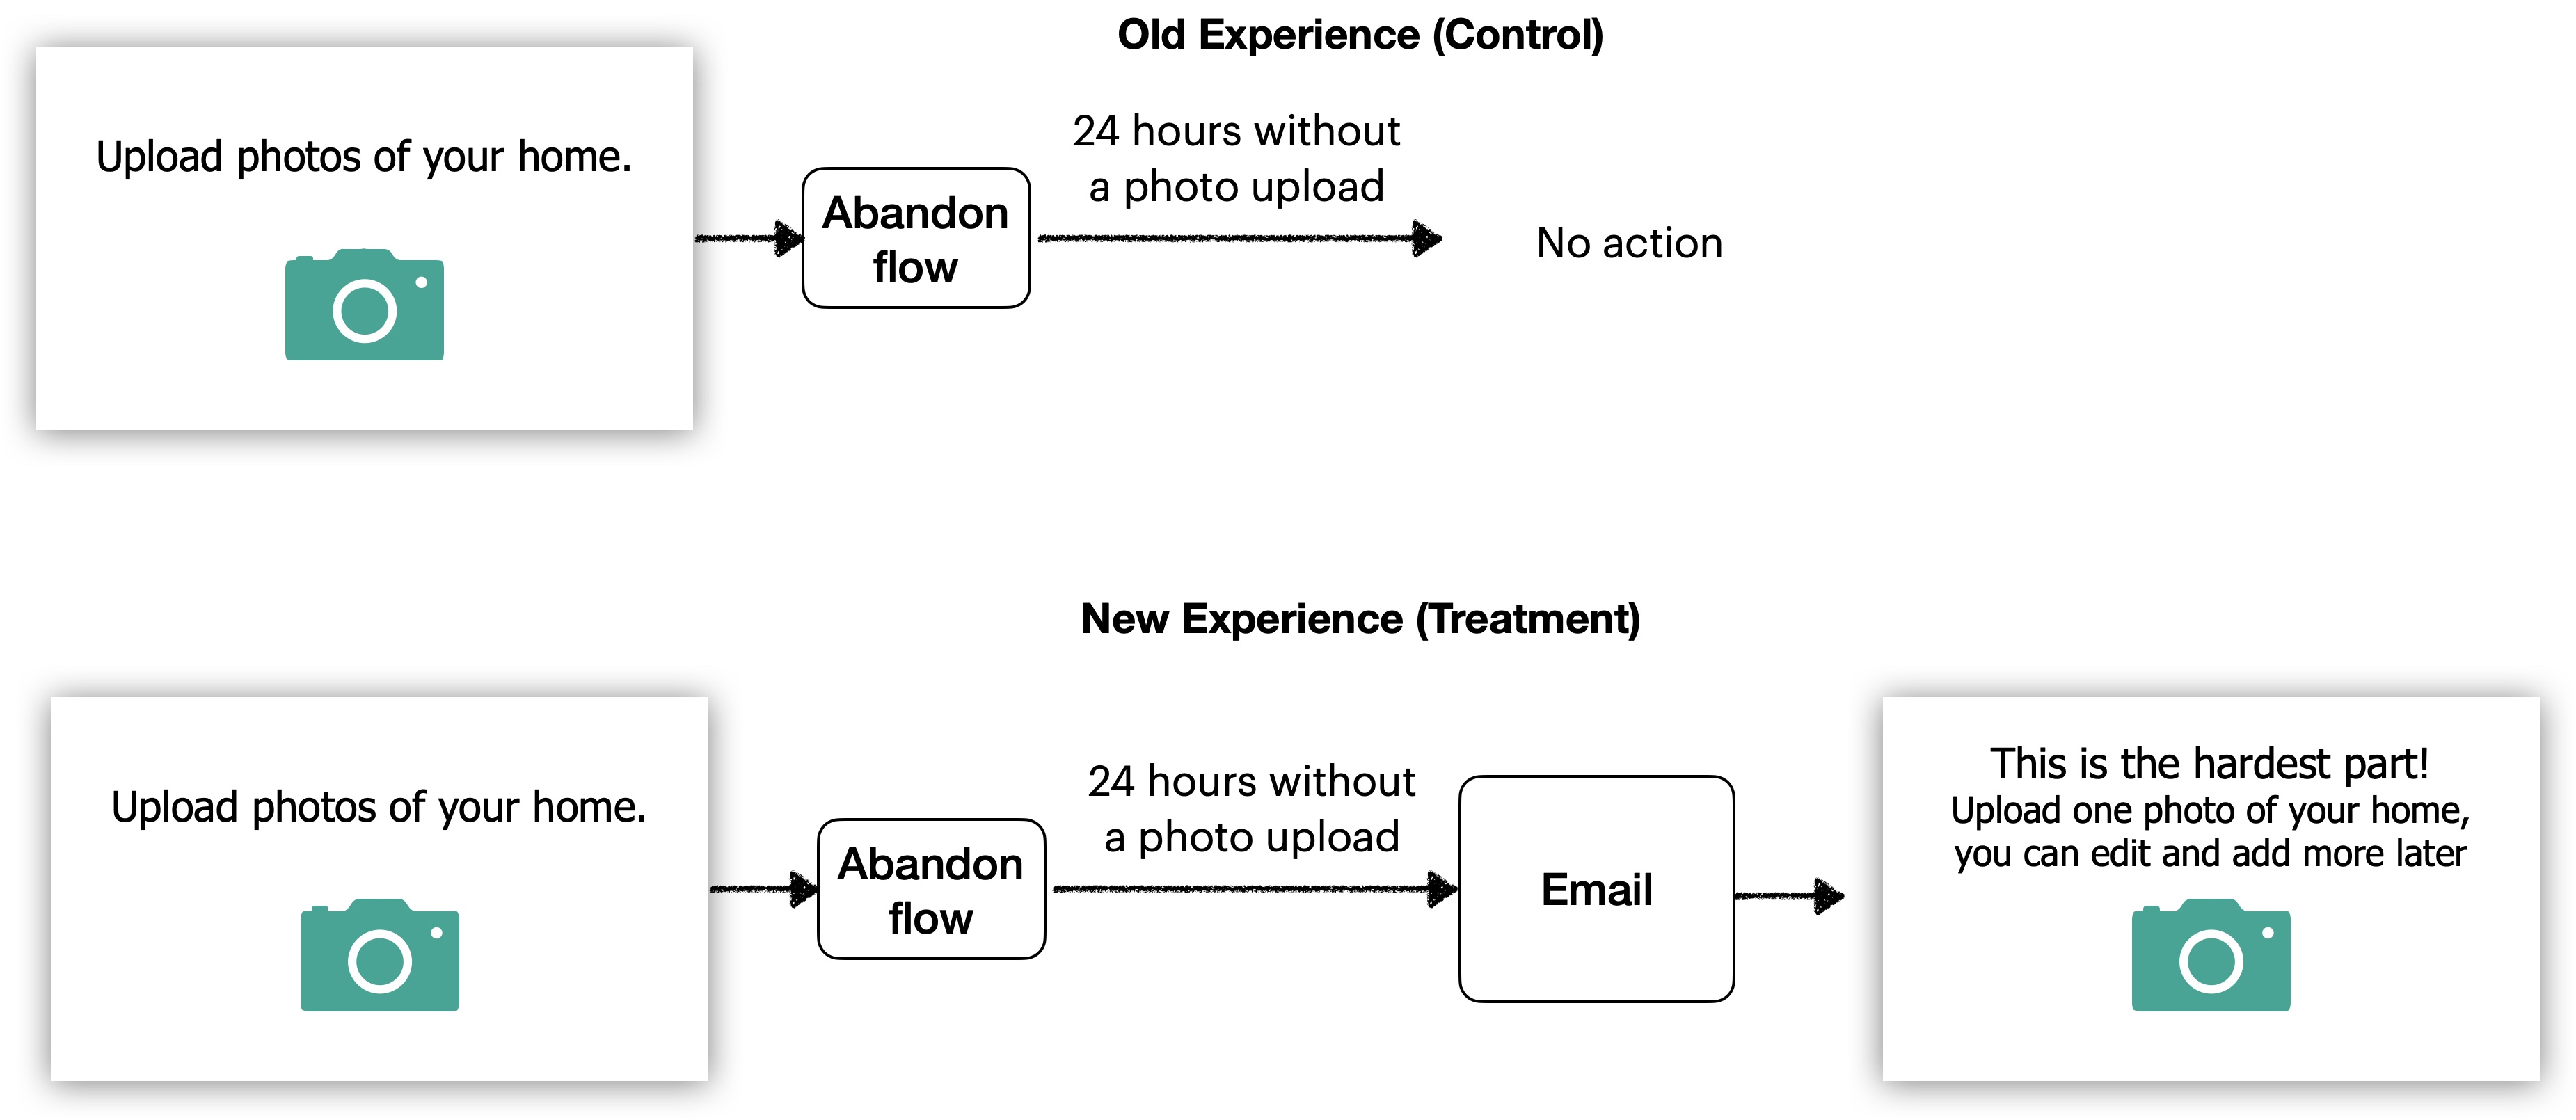

Again we provide you some details of the test design below.

### Task 2.a. Design: How long should the test run and how will the launch/ no launch decision be made?

Assume that there are 1000 new users visiting the triggering point each day and the cohort-book rate for that group is 10%. This is because we're subsetting to the users who exit the flow and they're unlikely to convert on their own. After all, they did leave the flow in the first place. PaM doesn't have a prior on how long she's willing to run it or how big of a change she expects, so please bring her some options.

Triggering Details: The test should be triggered when someone has abandoned the flow from the upload photos page and has not uploaded a photo within 24 hours of abandoning the flow. Note that the triggering should happen even if they don't receive an email.

_______________________________________________
_______________________________________________
**ANSWER**

HYPOTHESIS: 
- If we send an email and customize the landing page for people who got stuck on the photo upload step, new booked listings will increase because more users will complete the flow (there will be more active listings).

ASSUMPTIONS:

| **User journey step**                | **Conversion rate from last step** | **Conversion rate from start** | **Median time since last step** |
|--------------------------------------|------------------------------------|--------------------------------|---------------------------------|
| Start onboarding flow                | N/A                                | N/A                            | N/A                             |
| Publish home/ finish onboarding flow | ??%                                | ??%                            | 2 hours                         |
| Home is booked by a guest            | ??%                                | 10%                            | 7 days                          |

DESIRED MINIMUM DETECTABLE EFFECT:
- 10%

ANSWER: 
- Given that 1k users pass through the trigger point daily, I suggest a 42-day runtime for the A/B test. In the initial 29 days, we will see a total of 29k users join the test. Dividing equally between control and treatment, this translates to 14.5k users per group. Samples of this size will enable us to detect a minimum relative effect of 10% with 80% statistical power, offering adequate sensitivity for our analysis. The following 6 days are to account for weekly seasonality, and the  concluding 7 days are to allow users who entered the process on the 35th day to finalize their cycle.

DURATION OF THE A/B TEST: 
- 42 days

LAUNCH CRITERIA: 
- If the target significantly improves without substantial negative impact to the guardrail.
_______________________________________________
_______________________________________________

### Task 2.b. Analysis

After discussing the options with PaM, you collectively decided to run the test for 35 days to detect a 10% change or greater with a little buffer. Those in the control group who return to the flow probably need more time to publish and book than the average host, so you want to ensure you build in time to capture those conversions.

Please analyze the results and summarize the findings and recommendations below.

Note: Only use a user segment when you have a reason to do so.

In [26]:
# Read the CSV file into a dataframe
df_upload_photos = pd.read_csv('data/upload_photos.csv')

# Run the A/B test
df_results = build_results_dataframe(
    data_frame=df_upload_photos,
    metrics=['new_booked_listing','new_cancelled_listing'],
    features=None,
    ci=0.95,
    chi=True,
)

# Display the results
display(df_results)

,rel_diff,abs_diff,p,ci_lo,ci_hi,ctrl_size,trt_size,chi_sq_p
new_booked_listing,-44.48%,-6.200,0.0000,-57.2%,-31.75%,1924,3672,0.0000
new_cancelled_listing,-32.63%,-0.120,0.4573,-118.69%,53.42%,1924,3672,0.0000


_______________________________________________
_______________________________________________
**ANSWER**

CHI-SQUARED TEST FOR ASSIGNMENT IMBALANCE:

| **control samples** | **treatment samples** | **chi-squared p value** |
|---------------------|-----------------------|-------------------------|
|         1924        |          3672         |          0.0000         |


CONCLUSION: 
- The results of the chi-squared test, with an extremely small p-value (9.26e-121), indicate that the uneven assignment of users to the control and treatment is unlikely to have occurred by random chance. This suggests a significant imbalance in the assignment process. We will need to discuss this with engineering to determine the cause. Once remedied, the A/B test can be re-run.
_______________________________________________
_______________________________________________
  

### What happened?

You went to the engineer who implemented the A/B test and had them walk through how users were cohorted. Turns out, the triggering moment was not identical for the control and treatment group, which is the likely culprit of the assignment imbalance. It's a bummer, but everyone learned from the experience and you plan on starting a new test with the triggering moment fixed.

## Task 3: New map service for Africa

It is a known problem that the company you work with to confirm and locate the address of a home struggles a LOT in Africa. User research has found that hosts in Africa need to spend a substantial amount of time moving the pin to find their actual location from the suggested spot- if they find it at all. You hypothesize this is the primary reason conversion is so low through the maps section of the onboarding flow. A new player has come on the market, and the team wants to determine if using them helps with conversion through the maps section (see below). Since the change is on the backend, the UI would look mostly the same.

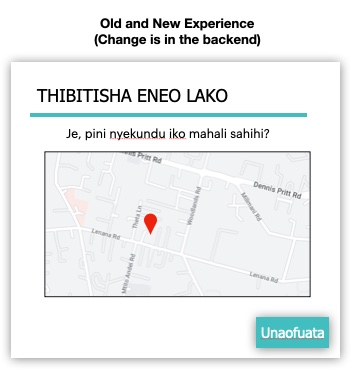

### Task 3.a. Design: How long should the test run and how will the launch/ no launch decision be made?

You can assume that about 500 new users from Africa arrive in the flow each day, and the cohort to book rate for that population is 12%. Note that prior to this page, the user enters in their address including the country.

The new service is significantly more expensive than the old one, and it might anger your existing vendor, so this change is only worth if it the relative increase is more than 10% for the impacted population. PaM told you they are fine running it up to 2 months because it's a really important decision, though of course, less is preferable if you can get enough signal in that time.

Triggering Moment: Users should be put in the test when they land on the maps page, if the address is in Africa.

_______________________________________________
_______________________________________________
**ANSWER**

HYPOTHESIS: 
- If we use the new service to confirm and locate the address in Africa, new booked listings will increase because it will correctly identify the location in Africa and reduce friction for the host (more active listings).

ASSUMPTIONS:

| **User journey step**                | **Conversion rate from last step** | **Conversion rate from start** | **Median time since last step** |
|--------------------------------------|------------------------------------|--------------------------------|---------------------------------|
| Start onboarding flow                | N/A                                | N/A                            | N/A                             |
| Publish home/ finish onboarding flow | ??%                                | ??%                            | 2 hours                         |
| Home is booked by a guest            | ??%                                | 12%                            | 7 days                          |

DESIRED MINIMUM DETECTABLE EFFECT: 
- 10%

ANSWER: 
- Given that 500 users pass through the trigger point daily, I suggest a 56-day runtime for the A/B test. In the initial 47 days, we will see a total of 23.5k users participate in the test. Dividing equally between control and treatment, this translates to 11.75k users per group. Samples of this size will enable us to detect a minimum relative effect of 10% with 80% statistical power, offering adequate sensitivity for our analysis. The following 2 days are to account for weekly seasonality, and the concluding 7 days are to allow users who began the process on the 49th day to finalize their cycle.

DURATION OF THE A/B TEST: 
- 56 days

LAUNCH CRITERIA: 
- If the target significantly improves without substantial negative impact to the guardrail.
_______________________________________________
_______________________________________________

### Task 3.b. Test analysis

Please analyze the test and summarize the learnings and recommendations for PaM and the team below with the A/B test data provided.

Note: Only use a user segment when you have a reason to do so.

In [27]:
# Read the CSV file into a dataframe
df_africa_map_diluted = pd.read_csv('data/africa_map.csv')

# Filter for africa
df_africa_map_not_diluted = df_africa_map_diluted.query("continent == 'africa'")


# Loop through the diluted and not diluted data
for diluted in [True, False]:
  print(f"DILUTED: {diluted}")
  
  # Choose the appropriate DataFrame based on the loop iteration
  df_africa_map = df_africa_map_diluted if diluted else df_africa_map_not_diluted

  # Run the A/B test
  df_results = build_results_dataframe(
      data_frame=df_africa_map,
      metrics=['new_booked_listing','new_cancelled_listing'],
      features=None,
      ci=0.95,
      chi=True,
  )

  # Display the results
  display(df_results)

DILUTED: True


,rel_diff,abs_diff,p,ci_lo,ci_hi,ctrl_size,trt_size,chi_sq_p
new_booked_listing,0.41%,0.100,0.5554,-0.96%,1.78%,122341,122645,0.5391
new_cancelled_listing,41.61%,0.510,0.0000,33.78%,49.45%,122341,122645,0.5391


DILUTED: False


,rel_diff,abs_diff,p,ci_lo,ci_hi,ctrl_size,trt_size,chi_sq_p
new_booked_listing,4.39%,1.110,0.0467,0.06%,8.71%,12233,12266,0.8330
new_cancelled_listing,18.93%,0.250,0.1017,-3.74%,41.61%,12233,12266,0.8330


_______________________________________________
_______________________________________________
**ANSWER**

### DILUTED DATA

| **metric**            | **rel-diff** | **p-val** | **ci-lo** | **ci-hi** |
|-----------------------|-------------------------|--------------|------------|-------------|
| new_booked_listing    |          0.41%             | 0.5554       | -0.96%      | 1.78%      |
| new_cancelled_listing | 41.61%                  | 0.0000       | 33.78%     | 49.45%       |

**Target Metric: New Booked Listing**

- We see that the treatment group's conversion rate for new booked listings is 0.41% higher relative to the control group.

- The p value well above 0.05 so it is unlikely that the observed difference is statistically significant.

**Guardrail Metric: New Cancelled Listing**

- We see that the treatment group's conversion rate for new canceled listings is 23.4% higher relative to the control group.

- The p value is well under 0.05 so it is likley that the observed difference is statistically significant.

### UNDILUTED DATA

| **metric**            | **rel-diff** | **p-val** | **ci-lo** | **ci-hi** |
|-----------------------|-------------------------|--------------|------------|-------------|
| new_booked_listing    |          4.39%             | 0.0467       | 0.06%      | 8.71%      |
| new_cancelled_listing | 18.93%                  | 0.1017       | -3.74%     | 41.61%       |

**Target Metric: New Booked Listing**

- We see that the treatment group's conversion rate for new booked listings is 4.39% higher relative to the control group.

- The p value is just under 0.05 so it is likely that the observed difference is statistically significant.

**Guardrail Metric: New Cancelled Listing**

- We see that the treatment group's conversion rate for new canceled listings is 18.93% higher relative to the control group.

- The p value is over 0.05 so it is unlikely that the observed difference is statistically significant.

### CONCLUSION

- The diluted data include users for whom the map accuracy was not a critical issue, so the overall effect appears to have been watered down. This is probably why, for global data, we see a negligible change in new bookings. Futhermore, the significant increase in cancellations globally is probably due to factors other than the map change.

- In contrast, when filtering for the African users, the issue with map accuracy is more pronounced, making it more likely that improvements in this area would lead to a noticeable increase in conversions. Changing the map does not appear to increase cancellations, however the confidence interval does lean heavier to the positive side, so it may be worth monitoring post-implementation.

- Despite the likely improvement from the map change, the uplift in new bookings for African users does not surpass the 10% threshold set by PaM, peaking at a potential 8.71% increase. Given this modest gain, coupled with the broader strategic and cost implications, the adoption of the new map service is not recommended at this time. Should future circumstances change, revisiting this decision may be warranted.

RECOMMENDATION: 
- Do NOT implement the change to the map.
_______________________________________________
_______________________________________________

### What happened?

You asked the engineer who implemented the test: "Might we have missed the filter for only cohorting users with African addresses?". Turns out, yup. Since the test has run its course, you decided to subset to the relevant population and use that as the result, rather than starting a new test from scratch. The result you found was not above the threshold specified by PaM, so everyone decided to keep them on the old map service, for now. The result being positive sparked a broader conversation about if there might other negative business impacts- bad guest experience, support tickets, etc., that should be factored into the decision beyond a simple increase in NBL. You're getting a little uncomfortable, the test was not designed to take those into account. But in the end, the business partners decide that they'll monitor the support tickets around this issue and revisit the decision if it seems to be an issue in the future.

## Task 4: Break out into two pages

You've noticed that only a few hosts are selecting amenities, and with offline correlation analysis, you found that amenities are connected to the likelihood of being booked. The team hypothesizes that hosts might not be selecting the amenities because it's low on a long page, so they want to test putting it on its own page.

See the UI change below.

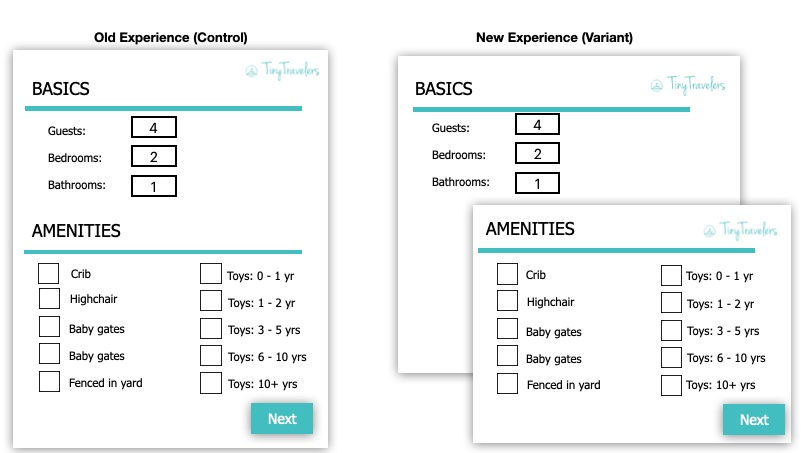

### Task 4.a. Test design by answering the following...

#### Task 4.a.i. When should the test be triggered?

_______________________________________________
_______________________________________________
**ANSWER**

When the user clicks the next button that takes them to what would be either the basics + amenities page (control) or the basics page (treatment).
_______________________________________________
_______________________________________________

#### Task 4.a.ii. What is the hypothesis?

_______________________________________________
_______________________________________________
**ANSWER**

If we change the amenities it will increase booked listings, because active listings will be more attractive (more ammenities) to potential guests.
_______________________________________________
_______________________________________________

#### Task 4.a.iii. How long should the test run and how will the launch/ no launch decision be made?

You can assume that about 5K new users arrive in the flow each day. And the cohort to book rate is 20%.

_______________________________________________
_______________________________________________
**ANSWER**

ASSUMPTIONS:

| **User journey step**                | **Conversion rate from last step** | **Conversion rate from start** | **Median time since last step** |
|--------------------------------------|------------------------------------|--------------------------------|---------------------------------|
| Start onboarding flow                | N/A                                | N/A                            | N/A                             |
| Publish home/ finish onboarding flow | ??%                                | ??%                            | 2 hours                         |
| Home is booked by a guest            | ??%                                | 20%                            | 7 days                          |

DESIRED MINMUN DETECTABLE EFFECT: 
- 5%

ANSWER:

- Given that 5k users pass through the trigger point daily, I suggest an 21-day runtime for the A/B test. In the initial 11 days, we will see a total of 55k users participate in the test. Dividing equally between control and treatment, this translates to 27.5k users per group. Samples of this size will enable us to detect a minimum relative effect of 5% with 80% statistical power, offering adequate sensitivity for our analysis. The following 3 days are to account for weekly seasonality, and the concluding 7 days are to allow users who began the process on the 14th day to finalize their cycle.

DURATION OF THE A/B TEST: 
- 21 days

LAUNCH CRITERIA: 
- If the target significantly improves without substantial negative impact to the guardrail.

_______________________________________________
_______________________________________________

### Task 4.b. Test analysis

Please analyze the test and summarize the learnings and recommendations for PaM and the team below with the A/B test data provided.

In [28]:
# Read the CSV file into a dataframe
df_split_page = pd.read_csv('data/split_page.csv')

# Run the A/B test
df_results = build_results_dataframe(
    data_frame=df_split_page,
    metrics=['new_booked_listing','new_cancelled_listing'],
    features=None,
    ci=0.95,
    chi=True,
)

# Display the results
display(df_results)

,rel_diff,abs_diff,p,ci_lo,ci_hi,ctrl_size,trt_size,chi_sq_p
new_booked_listing,4.73%,0.390,0.0084,1.21%,8.25%,69278,70220,0.0117
new_cancelled_listing,7.42%,0.020,0.5013,-14.2%,29.03%,69278,70220,0.0117


What happened at a high-level to the target (new booked listings) and guardrail (new cancelled listings) and do you recommend a launch or not based on that?

Given unlimited time, what follow-up analysis and testing might you do? (No coding on this - just thinking).

_______________________________________________
_______________________________________________
**ANSWER**

RESULTS:

| **metric**            | **rel-diff** | **p-val** | **ci-lo** | **ci-hi** |
|-----------------------|-------------------------|--------------|------------|-------------|
| new_booked_listing    |          4.73%           | 0.0084       | 1.21%      | 8.25%      |
| new_cancelled_listing | 7.42%                  | 0.5013       | -14.2%     | 29.03%       |


CONCLUSION:

**Target:** Moving the amenities selection to its own page seems to have had a positive impact on the number of new bookings, suggesting that the hypothesis (hosts were not selecting amenities due to its placement on a long page) was correct.

**Guardrail:** In addition, the test didn't show a significant change in cancellations. A good portion of the confidence interval is in the positive so it may be worth further monitoring post-implementation.

**Imbalance:** However, based the on the chi-squared test, there is a good chance the allocation between control and treatment wasn't perfectly random. This imbalance could potentially confound the results. For example, if more experienced hosts who already know the importance of amenities were disproportionately placed in the control, this would dampen the positive impact, and vice versa.

**Recommendation:** Despite this imbalance, it is still probably reasonable to consider implementing the change.

**Follow-up Analysis:**

- Should the imbalance be rectified, re-running the test may be advisable to confirm the results prior to implementing the change on a permanent basis.

- A segmentation analysis differentiating between new and experienced hosts could elucidate the observed increase in bookings. It is possible that a large positive impact on one segment could mask a minor negative impact on the other.

- A device-specific segmentation analysis could reveal if the UI change has a differential impact. On mobile devices, where screen space is limited, the change might be more beneficial. Conversely, for web users, adding a separate page for amenities might make the listing process appear lengthier and more cumbersome, potentially increasing drop-off rates.
_______________________________________________
_______________________________________________

# SECTION 3: Early Results - How to Check Safely

## Background

Welcome back **TinyTravelers**'s awesome product data scientist! You have developed strong relationships with PaM and the engineers on your team. You are a smooth, efficient, happy product-improving machine. Leadership has taken note and has given your team more resources to grow. You now have some new engineers and a new product manager, Maximus Impact ("Max" for short).

Like in past weeks, three A/B tests need to be designed and analyzed. Some back and forth communication with Max might also be needed.

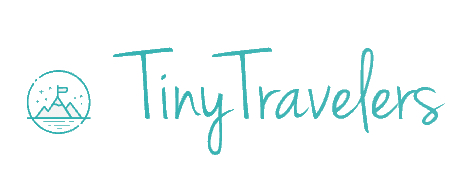

## Task 1: Landing page change

The team has a hypothesis that a photo of a family instead of a baby will be more compelling to potential hosts. The thought of a baby staying alone in a house is terrifying. But a family with older kids and adults? Much less scary. That's the idea, anyways. So they want to try testing a photo for the landing page. See the design change below.

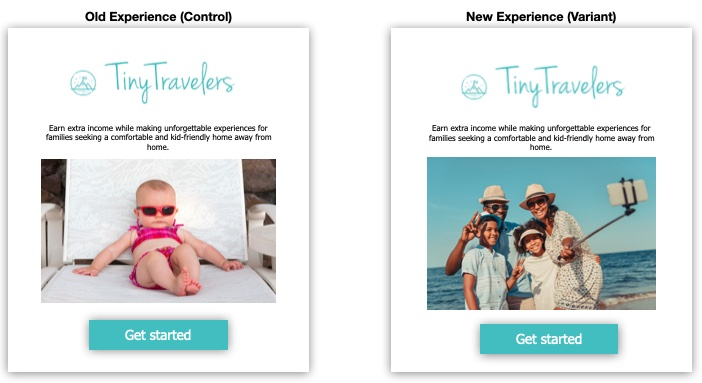

### Task 1.a. Test Design: How long should the test run and how will the launch/ no launch decision be made?

Like with prior weeks, we first want to design the test. 

You need to determine how long the test should run and how will the final ship vs no ship decision be made. 

Triggering Moment: The test should be triggered upon loading the landing page.

You can assume there will be 6000 new users per day reaching the landing page, and the cohort-to-book rate is 20%. Max hopes to detect a 2% change if it’s there, but he also doesn't want the test to run for more than three weeks as it's blocking some other work the team hopes to do.

If you find that 2% is not feasible in 3 weeks, write how you would communicate the trade-off to Max

_______________________________________________
_______________________________________________
**ANSWER**

HYPOTHESIS: 
- If we show a picture of a family instead of a baby alone on the landing page it will increase new active listings and therefore new booked listings because hosts will be more inclined to share their homes.

ASSUMPTIONS:

| **User journey step**                | **Conversion rate from last step** | **Conversion rate from start** | **Median time since last step** |
|--------------------------------------|------------------------------------|--------------------------------|---------------------------------|
| Start onboarding flow                | N/A                                | N/A                            | N/A                             |
| Publish home/ finish onboarding flow | ??%                                | ??%                            | 2 hours                         |
| Home is booked by a guest            | ??%                                | 20%                            | 7 days                          |

DESIRED MINIMUM DETECTABLE EFFECT:
- 2%

ANSWER:

- Given that 6k users pass through the trigger point daily, achieving the desired minimum detectable effect of 2% would require a sample size of 158k users per group. Accumulating this number of users would take approximately 53 days. Adding an extra 3 days to account for weekly seasonality, and an additional 7 days to allow users who entered the test on the last day to complete their cycle, the total duration extends to 63 days, or about 9 weeks.

- However, management has requested a maximum test duration of 3 weeks. To meet this constraint while maintaining an 80% statistical power and a 5% significance level, we need to adjust the minimum detectable effect (MDE) to approximately 4%. This adjustment is based on 14 days to accumulate users, plus 7 days for the last entrants to complete their cycle.

- The key trade-off in this adjustment is sensitivity. By increasing the MDE to 4%, we can complete the test within the 3-week timeframe and confidently use the results for decision-making. However, this means any changes in the conversion rate less than 4% may not be detected. If the test results show a neutral outcome, we can still proceed with implementing the landing page change, but with continued monitoring. Worst-case scenario would be a negative effect not exceeding 4% that we catch an additional 6 weeks down the line.

DURATION OF THE A/B TEST: 
- 21 days (3 weeks)

LAUNCH CRITERIA: 
- If SS positive or neutral effect on the target without substantial negative impact to the guardrail.
_______________________________________________
_______________________________________________

### Task 1.b. Test analysis

You bring these MDE vs run-time points to Max to align on the run-time. After discussing the run time vs. detectable change with Max, you aligned on running the test for four weeks with an alpha of 0.10. That means you will launch the test if the point estimate for new booked listings is positive with a p-value is less than 0.10.

Please analyze the test and summarize the learnings and recommendations for Max and the team below with the A/B test data provided.

In [29]:
# Read the CSV file into a dataframe
df_landing_page = pd.read_csv('data/landing_page.csv')

# Run the A/B test
df_results = build_results_dataframe(
    data_frame=df_landing_page,
    metrics=['new_booked_listing','new_cancelled_listing'],
    features=None,
    ci=0.95,
    chi=True,
)

# Display the results
display(df_results)

,rel_diff,abs_diff,p,ci_lo,ci_hi,ctrl_size,trt_size,chi_sq_p
new_booked_listing,2.16%,0.180,0.1911,-1.08%,5.39%,83535,83862,0.4242
new_cancelled_listing,10.46%,0.030,0.3044,-9.5%,30.42%,83535,83862,0.4242


_______________________________________________
_______________________________________________
**ANSWER**

RESULTS:

| **metric**            | **rel-diff** | **p-val** | **ci-lo** | **ci-hi** |
|-----------------------|-------------------------|--------------|------------|-------------|
| new_booked_listing    |          2.16%          | 0.1910       | -1.08%      | 5.39%      |
| new_cancelled_listing | 10.46%                  | 0.3044       | -9.5%     | 30.42%       |

**Target Metric: New Booked Listing**

- We see that the treatment group's conversion rate for new booked listings is 2.16% higher relative to the control group.

- The p value is well over 0.05, indicating that the increase is not statistically significant.

**Guardrail Metric: New Cancelled Listing**

- We see that the treatment group's conversion rate for new canceled listings is 10.46% higher relative to the control group.

- The p value is well over 0.05, indicating that the increase is not statistically significant.

CONCLUSION:

- These results suggest that the change to the landing page is unlikely to impact new booked listings by more than 4% in either direction. Furthermore, we did not observe a statistically significant increase in new canceled listings. However, the broad confidence interval for new canceled listings, reaching an upper limit of 30.42%, indicates a significant level of uncertainty. Therefore, I recommend a cautious approach, proposing that we delay implementing this change until additional data can be gathered and the effects reassessed.

_______________________________________________
_______________________________________________

### Task 1.c. Stakeholder management

You share your recommendation in the stakeholder review meeting. Max speaks up:

"Looks to me like this change was actually solid, +2% on new booked listings! And the p-value is pretty close to 0.1, so I think we should ship."

How do you reply?

_______________________________________________
_______________________________________________
**ANSWER**

Optimism about the +2% increase in new booked listings is understandable, and the p-value being not too far off from 0.1 is somewhat borderline. However, it is important that we adhere to the decision criteria we set in advance. These criteria are in place to avoid interpreting the results too flexibly or subjectively. While there is an argument to be made for proceeding with the change, it is important to recognize the risks involved, such as:
   
   - potentially no true effect 1 out of 5 times (p=0.19)
   - potential negative effect up to -4%
   - uncertainty surrounding the effect on new cancelations

If we decide to move forward, it should be with a full awareness of these risks and a commitment to closely monitor the impact. We must also be ready to reassess and potentially reverse the change if new data indicates unforeseen negative effects.
_______________________________________________
_______________________________________________

## Task 2: Recommended Price

Given the success of the default title in [Section 1 Task 2](#Task-2:-Design-and-analyze-a-test!-Auto-generate-title.) (remember chatGPT &rarr; 📈 &rarr; 🍾?), the team came up with the idea to try a default price for homes as well. At a high level, to come up with the recommended price, the team uses information that the host has entered about the home so far (e.g., location, how many guests can fit, etc.) and data from the existing home to come up with a price they think this house would be booked at. The model predicts a price while the page is loaded to ensure it's ready to display to the host when they see the page.

See the UI change below.

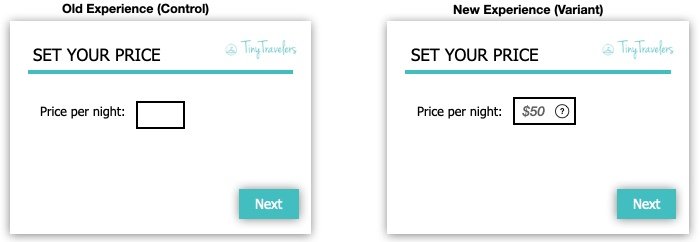

### Task 2.a. Test design by determining run time

Triggering Moment: This test should be triggered when a user clicks "next" on the previous page.

You can assume that about 4K new users arrive on the price page of the onboarding flow each day. And the cohort-to-book rate is estimated to be 40% because the cohorting happens later in the flow when only the higher intent people are still there. Given that the default title had over a 10% relative increase  (Section 1), Max is optimistic about this change. Still, he also recognizes this is a different kind of problem and later in the flow, so the impact might not be that big. So he'd like you to bring back some run-time vs. minimal detectable effect options.

Please share some run time vs MDE options.

_______________________________________________
_______________________________________________
**ANSWER**

HYPOTHESIS: 
- If we default the price to a recommended value, it will increase new booked listings because it will reduce friction in the onboarding flow, resulting in more new active listings.

ASSUMPTIONS:

| **User journey step**                | **Conversion rate from last step** | **Conversion rate from start** | **Median time since last step** |
|--------------------------------------|------------------------------------|--------------------------------|---------------------------------|
| Start onboarding flow                | N/A                                | N/A                            | N/A                             |
| Publish home/ finish onboarding flow | ??%                                | ??%                            | 2 hours                         |
| Home is booked by a guest            | ??%                                | 40%                            | 7 days                          |

MINIMUM DETECTABLE EFECT:

| **Minimal detectable relative impact**                | **Run-time (days)** |
|--------------------------------------|------------------------------------|
| 10%                | 14                                |
| 5% | 14                                |
| 3%            | 21                                |
| 2%            | 42                                |
| 1%            | 126                                |    

_______________________________________________
_______________________________________________

### Task 2.b. Stakeholder management

After discussing the options with Max, you collectively decide that 28 days is a good balance. We like to stick with run-times in week increments so sacrificing the 29th day seems OK. The team put a lot of work into developing the algorithm so Max wants to position them to detect a 2.1% change.

The test starts off and everyone is feeling cautiously optimistic and excited for more champagne 🍾.

About 48 hours pass when Max shows up at your desk.

"SOMETHING IS WRONG! The results look really bad. I know we said this was going to run for 28 days, but I feel like something is up. Can you take a look?"

You oblige. The results below are the test results after running for 2 days. 

Please analyze the results and share your reply to Max.

In [30]:
# Ignore specific runtime warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Read the CSV file into a dataframe
df_price_1_early = pd.read_csv('data/price_1_early.csv')

# Run the A/B test
df_results = build_results_dataframe(
    data_frame=df_price_1_early,
    metrics=['new_booked_listing','new_cancelled_listing'],
    features=['full_dataset', 'continent', 'booked_previously', 'device'],
    ci=0.95,
    chi=True,
)

# Display the results
display(df_results)

Explore the data carefully, and try to determine what went wrong. Is there any additional data would you ask for to help investigate what happened?

_______________________________________________
_______________________________________________
**ANSWER**

- After 48 hours, we have collected around 10% of our target data, which provides us an early glimpse into the test results. At this stage, we are observing a notably strong SS negative effect, suggesting there might be an issue with the test.

- The chi-square tests do not show any significant assignment imbalance, which is good. However, the absence of assignment imbalance does not rule out other issues, such as a more subtle form of imbalance or a bug affecting user experience.

- A closer look at the segment analysis reveals a marked discrepancy between the web and ios results compared to android. The android platform shows the same significant negative effect observed in the overall data, whereas the results for web and ios users are relatively neutral and not statistically significant. This pattern points towards a potential bug or UI issue specific to android devices.

- To investigate further, I recommend we collaborate with the engineering team to examine the implementation on android devices.
_______________________________________________
_______________________________________________


## Task 3: Recommended Price v2

The bug you identified in the initial price recommendation test has been resolved. The team wants to try again. The design you did in task 2 holds, and you and Max decide that 28 days is still a good run-time.

### Task 3.a. Stakeholder management

The 48 hour mark passes and the results look OK. Everyone gives a collective sigh of relief. But then after 3 days, Max shows up to your desk.

These results are SO GOOD. We should ship right now. You ask for a tapering of excitement while you look into the results.

Below we provide the data after 3 days of the test running. 

Please analyze the results and make a recommendation on how to proceed.

In [31]:
# Read the CSV file into a dataframe
df_price_2_early = pd.read_csv('data/price_v2_early.csv')

# Run the A/B test
df_results = build_results_dataframe(
    data_frame=df_price_2_early,
    metrics=['new_booked_listing','new_cancelled_listing'],
    features=None,
    ci=0.95,
    chi=True,
)

# Display the results
display(df_results)

,rel_diff,abs_diff,p,ci_lo,ci_hi,ctrl_size,trt_size,chi_sq_p
new_booked_listing,14.2%,0.570,0.0015,5.41%,23.0%,25360,25276,0.7089
new_cancelled_listing,-10.82%,-0.010,0.7388,-74.39%,52.76%,25360,25276,0.7089


_______________________________________________
_______________________________________________
**ANSWER**

- While the early results showing an SS positive effect in new booked listings are encouraging, it is crucial to approach these findings with caution. At this 3-day mark, our data is still in the early stages, and making decisions based on these results carries a risk of false positives.

- Peeking at results primarily serves to ensure the test is running correctly, rather than confirming our hypothesis. Early data can be influenced by the novelty effect or may be non-representative of the full population, leading to misleading conclusions.

- Therefore, I recommend continuing the test as originally planned without making premature changes based on these initial findings. Once we have collected the complete data set over the designated test period, we can proceed with our analysis and make informed decisions based on the full scope of the data.
_______________________________________________
_______________________________________________

### Task 3.b. Test analysis

Max agrees to wait the full 28 days, though he can't help but ask about how the test is doing a few more times :) 

The four weeks are up and it's time to look at the results. 

Please analyze the data provided below, and share a summary and recommendation on how to proceed.

In [32]:
# Read the CSV file into a dataframe
df_price_2 = pd.read_csv('data/price_v2.csv')

# Run the A/B test
df_results = build_results_dataframe(
    data_frame=df_price_2,
    metrics=['new_booked_listing','new_cancelled_listing'],
    features=None,
    ci=0.95,
    chi=True,
)

# Display the results
display(df_results)

,rel_diff,abs_diff,p,ci_lo,ci_hi,ctrl_size,trt_size,chi_sq_p
new_booked_listing,6.64%,1.260,0.0000,4.19%,9.09%,55853,55434,0.2091
new_cancelled_listing,-0.75%,-0.010,0.9024,-12.65%,11.16%,55853,55434,0.2091


_______________________________________________
_______________________________________________
**ANSWER**

I am pleased to see that there has been an SS positive effect on new booked listings and that there was no detectable effect on new canceled listings. We can move forward with implementing the change.
_______________________________________________
_______________________________________________

### Task 3.c Deep dive in analysis

Although everyone is happy the results ended positive in the end and the price recommender was able to launch, you want to understand _why_ the early results were so positive.

#### Task 3.c.i. What hypotheses do you have for why the early results were so positive?

Why do you think the early results were so much more positive than the end results? What analysis could you do to confirm or reject those hypthesis?

No code here- just thoughts.

_______________________________________________
_______________________________________________
**ANSWER**

Several hypotheses could explain why the early results of our A/B test appeared more positive than the results observed at the end of the testing period.

 - **Novelty Effect:** Users might initially respond more positively to new features or changes simply because they are new and intriguing.

 - **Non-Representative Sample:** The early sample of users might not represent the broader user base, possibly due to day-of-week variation, an unusual event (like a concert ticket sale), or a predominance of power users.

To confirm or reject these hypotheses, we can undertake the following analyses:

  - **Conversion Rate Analysis Over Time:** Examine how the conversion rate changes throughout the duration of the A/B test to determine if the effect diminishes, which might be indicative of the novelty effect.

  - **Segment Analysis Over Time:** Conduct a segment analysis to track the composition of the samples over time to understand whether certain types of users were more prevalent in the early stages of the test.
_______________________________________________
_______________________________________________


#### Task 3.c.ii. Show the results over time

Do the results vary by the day someone was cohorted? What does this tell you?

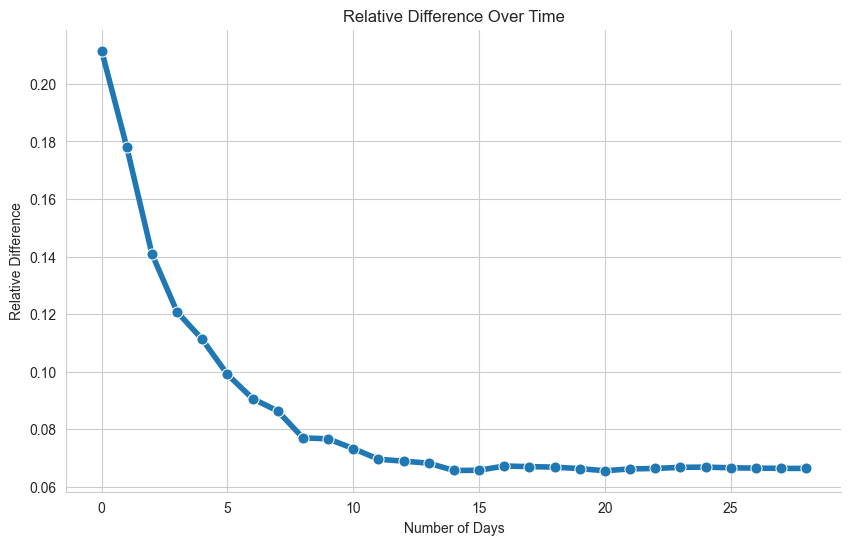

In [33]:
# Determine the maximum number of days in the dataset
n_days = int(df_price_2.cohort_day.max())

# Initialize lists to store calculated relative differences and p-values
rel_diff_list, p_list = [], []

# Loop through each day and perform calculations
for i in range(n_days + 1):
  
  # Calculate metrics for the subset of data up to the current day
  rel_diff, abs_diff, pvalue, ci_low, ci_high = calculate_results(
    df=df_price_2[df_price_2.cohort_day <= i], 
    metric='new_booked_listing',
    ci=0.95
  )
  
  # Append the calculated metrics to the respective lists
  rel_diff_list.append(rel_diff)
  p_list.append(pvalue)

# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(29), y=rel_diff_list, linewidth=4, marker='o', markersize=8)
sns.set_style("whitegrid")
sns.despine()
plt.title('Relative Difference Over Time')
plt.xlabel('Number of Days')
plt.ylabel('Relative Difference')

plt.show()

_______________________________________________
_______________________________________________
**ANSWER**

This plot shows that the effect tapers off over time possibly reflecting the novelty effect.
_______________________________________________
_______________________________________________

# SECTION 4: Concurrent Tests

## Background

TinyTraveler's rockstar data scientist- you made it to the final section! The engineers and Max are all rolling now, so you might need to think about running multiple tests at the same time.

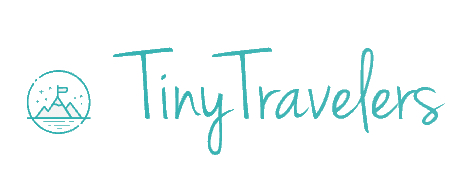

## Task 1: Two changes. One page. What should we do?

The team has two ideas they're optimistic about:

_Test A: Price recommendation algorithm update_: Last week, the team successfully implemented a version of the recommendation algorithm, resulting in a stat-sig lift to new booked listings (yay!). However, the team hypothesizes that the prices are still a bit high on average, so they tweaked the algorithm to be a bit more conservative and want to try this out.

_Test B: First booking discount_: Pricing has proven to be a successful lever for increasing new booked listings, so the team held a brainstorm to generate ideas other than tweaking the recommendation algorithm. Hosts might be willing to reduce the price for their first booking only. The team wants to test out a checkbox which will allow hosts to opt-in to a 10% discount on the first booking. See the design for the checkbox test below.

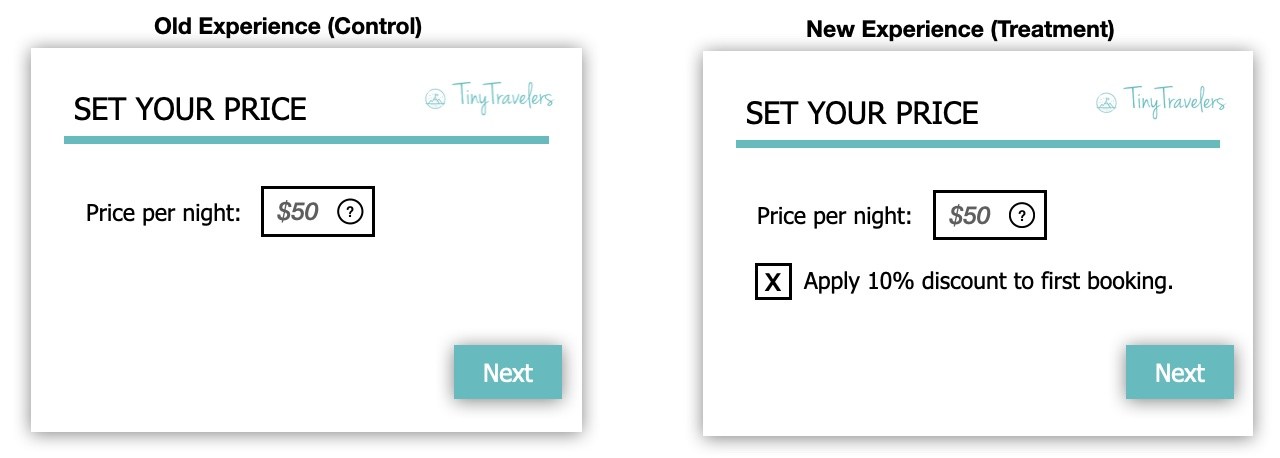

Unfortunately, both of these changes are on the same page in the onboarding flow. So they need your help figuring out how to proceed.

### Task 1.a. Test structure options

This week we discussed 3 possible approaches to measuring the impact of two tests:

* Waiting - Run one after another.
* Orthogonal - Run them at the same time with different randomizations.
* Split traffic - Run a multi-variant test

Which of the above the options do you think should be considered and not considered in this case? Which one would you recommend?

_______________________________________________
_______________________________________________
**ANSWER**

Without specific knowledge of the run-times, I would think the **orthogonal** approach would be the most suitable, considering that it:
  - optimizes power and time
  - mitigates dependencies
  - exhausts interaction effects

In addition, there probably are no undesirable interactions that we would want to avoid to streamline the process. However, it could be that potential hosts perceive the reduced price recommendation, in combination with being encouraged to offer a 10% discount, as off-putting and leave the funnel rather than acquiesce, reducing new active listings. But still, this definitly needs to be tested as it is just a possibility and no where as apparent as something like a pink button on a pink background.

**Splitting traffic** does not offer much benefit since we can easily handle the slightly more complex analysis that comes with orthogonal testing and there are not a burdonsome number (none in this case) of undesriable interactions we are trying to eliminate. In fact, there would be downsides to either power or time depending on the configuration.

Lastly, the **waiting** approach requires more time to carry out, the power is no better, and the added simplicity is negligible.
_______________________________________________
_______________________________________________

## Task 2. Test one way

**Test design - FYI :)**

After discussing the options with Max, you decide to proceed with an _orthogonal test_. The plan is to run each as a 50/50 test and then check for interaction in the analysis stage.

For both the algorithm and discount tests, you've aligned on the triggering moment being when someone clicks "next" on the previous page in the onboarding flow. So the hypotheses you're working with are:

* _Algorithm update_: If we update the price recommendation algorithm, new booked listings (NBL) will increase because the new price will appeal more to guests.

* _First booking discount_: If we add a checkbox allowing hosts to opt-in to discount their first booking, NBL will increase because the price will appeal more to guests.

Since you already ran a test on this page last week and the traffic is the same (~4K new users arriving on the page per day with an NBL conversion rate of 40%), the power analysis you did there holds. Max is OK with targeting a 2.1% relative lift so that this test will run for 28 days.

The test has run and the results are in! Please analyze the data provided, and share a summary and recommendation on how to proceed.

### Task 2.a. Analyze the tests individually

First, treat each test as independent and analyze them as you would normally.

In [34]:
# Read the CSV files into dataframes
df_price_algo = pd.read_csv('data/price_algo.csv')
df_checkbox_discount = pd.read_csv('data/checkbox_discount.csv')

print("PRICE ALGORITHM:\n")
# Run the A/B test
df_results_algo = build_results_dataframe(
    data_frame=df_price_algo,
    metrics=['new_booked_listing','new_cancelled_listing'],
    features=None,
    ci=0.95,
    chi=True,
)

# Display the results
display(df_results_algo)

print("CHECKBOX DISCOUNT:\n")
# Run the A/B test
df_results_discount = build_results_dataframe(
    data_frame=df_checkbox_discount,
    metrics=['new_booked_listing','new_cancelled_listing'],
    features=None,
    ci=0.95,
    chi=True,
)

# Display the results
display(df_results_discount)

PRICE ALGORITHM:



,rel_diff,abs_diff,p,ci_lo,ci_hi,ctrl_size,trt_size,chi_sq_p
new_booked_listing,-4.76%,-0.920,0.0001,-7.14%,-2.39%,55759,55776,0.9594
new_cancelled_listing,-0.03%,-0.000,0.9961,-12.12%,12.05%,55759,55776,0.9594


CHECKBOX DISCOUNT:



,rel_diff,abs_diff,p,ci_lo,ci_hi,ctrl_size,trt_size,chi_sq_p
new_booked_listing,3.12%,0.580,0.0134,0.65%,5.59%,55786,55749,0.9118
new_cancelled_listing,-5.9%,-0.060,0.3245,-17.63%,5.83%,55786,55749,0.9118


### Task 2.b. Check for interactions

Now that we know how the tests performed individually, it's time to see if there was an interaction effect. In other words, is the observed effect for Test A different for users in Test B's control vs Test B's treatment? And vice-versa.

For simplicity, assume that the two tests started and ended at the exact same time, with the same triggering moment. So every user should be in both tests, and the conversion events should match (e.g. someone who had an NBL in test A will also have an NBL in test B). 

In [35]:
# Copy dataframes to preserve the original ones
df_price_algo_c = df_price_algo.copy()
df_checkbox_discount_c = df_checkbox_discount.copy()

# Rename 'variant' column in df_price_algo to 'variantA'
df_price_algo_c.rename(columns={'variant': 'variantA'}, inplace=True)

# Rename 'variant' column in df_checkbox_discount to 'variantB'
df_checkbox_discount_c.rename(columns={'variant': 'variantB'}, inplace=True)

# Drop the redundant conversion data from `df_checkbox_discount`
df_checkbox_discount_c.drop(columns=['new_active_listing', 'new_booked_listing', 'new_cancelled_listing'], inplace=True)

# Merge the two DataFrames on 'user_id'
df_merged = pd.merge(df_price_algo_c, df_checkbox_discount_c, on='id_user')

# Reorder the columns
df_merged = df_merged[['id_user','new_active_listing', 'new_booked_listing', 'new_cancelled_listing', 'variantA', 'variantB']]

Now check the results for Test A by whether or not they are in the control vs treatment of Test B.

In [36]:
# Loop through each variant of Test B (Control and Treatment)
for idx, varB in enumerate(['control','treatment']):
    print(f'\nTest A (Price Recommendation Algorithm) >> Test B {varB.upper()}')
    
    # Filter the merged dataset for the current variant of Test B
    # This step isolates the data for Test B's control or treatment group 
    df_tmp = df_merged.loc[df_merged['variantB'] == varB].copy() 
    
    # Rename the 'variantA' column to 'variant' to match the expected input of the 'build_results_dataframe' function
    df_tmp['variant']=df_tmp['variantA'] 

    # Run the A/B test
    df_results_discount = build_results_dataframe(
        data_frame=df_tmp,
        metrics=['new_booked_listing','new_cancelled_listing'],
        features=None,
        ci=0.95,
        chi=True,
    )

    # Display the results
    display(df_results_discount)


Test A (Price Recommendation Algorithm) >> Test B CONTROL


,rel_diff,abs_diff,p,ci_lo,ci_hi,ctrl_size,trt_size,chi_sq_p
new_booked_listing,-4.95%,-0.940,0.0042,-8.34%,-1.56%,27912,27874,0.8722
new_cancelled_listing,2.78%,0.030,0.7494,-14.29%,19.85%,27912,27874,0.8722



Test A (Price Recommendation Algorithm) >> Test B TREATMENT


,rel_diff,abs_diff,p,ci_lo,ci_hi,ctrl_size,trt_size,chi_sq_p
new_booked_listing,-4.58%,-0.900,0.0070,-7.92%,-1.25%,27847,27902,0.8158
new_cancelled_listing,-2.93%,-0.030,0.7375,-20.04%,14.18%,27847,27902,0.8158


And switch. Look at the results for Test B by whether or not they are in the control vs treatment of Test A.

In [37]:
# Loop through each variant of Test A (Control and Treatment)
for idx, varA in enumerate(['control','treatment']):
    print(f'\nTest B (Discount Checkbox Algorithm) >> Test A {varA.upper()}')
    
    # Filter the merged dataset for the current variant of Test A
    # This step isolates the data for Test A's control or treatment group
    df_tmp = df_merged.loc[df_merged['variantA'] == varA].copy()
    
    # Rename the 'variantB' column to 'variant' to match the expected input of the 'build_results_dataframe' function
    df_tmp['variant']=df_tmp['variantB']

    # Run the A/B test
    df_results_discount = build_results_dataframe(
        data_frame=df_tmp,
        metrics=['new_booked_listing','new_cancelled_listing'],
        features=None,
        ci=0.95,
        chi=True,
    )

    # Display the results
    display(df_results_discount)


Test B (Discount Checkbox Algorithm) >> Test A CONTROL


,rel_diff,abs_diff,p,ci_lo,ci_hi,ctrl_size,trt_size,chi_sq_p
new_booked_listing,2.93%,0.560,0.0952,-0.51%,6.37%,27912,27847,0.7831
new_cancelled_listing,-3.17%,-0.030,0.7118,-19.99%,13.65%,27912,27847,0.7831



Test B (Discount Checkbox Algorithm) >> Test A TREATMENT


,rel_diff,abs_diff,p,ci_lo,ci_hi,ctrl_size,trt_size,chi_sq_p
new_booked_listing,3.32%,0.600,0.0667,-0.23%,6.88%,27874,27902,0.9056
new_cancelled_listing,-8.55%,-0.080,0.3059,-24.91%,7.82%,27874,27902,0.9056


### Task 2.c. Summary and recommendation

Now that you've analyzed the results and checked for an interaction effect, please summarize your findings and recommend how to proceed. Options for moving forward include:

* Stop both tests
* Launch both tests
* Launch only one of the tests
* Run a new test with a different setup (e.g. if the results are inconclusive, you can follow up with a test trying just one combo)

_______________________________________________
_______________________________________________
**ANSWER**

RESULTS:

|**test** | **metric** | **rel-diff** | **p-val** | **ci-lo** | **ci-hi** |
|-----------|---------|---------|--------|----|------|
|$A$ (price algo)| booked_listing    |        -4.76%             | 0.0000       | -7.14%      | -2.39%      |
| |cancelled_listing | -0.03%                  | 0.9960       | -12.12%     | 12.05%       |
||
|$B$ (discount box)| booked_listing    |        3.12%             | 0.0134       | 0.65%      | 5.59%      |
|| cancelled_listing | -5.9%                  | 0.3245      | -17.63%     | 5.83%       |
|-------------------|----------------------------|-------------|-----------|------------|------------|
|$A$ >> $B_C$| booked_listing    |        -4.95%             | 0.0042       | -8.34%      | -1.56%      |
|| cancelled_listing | 2.78%                  | 0.7494       | -14.29%     | 19.85%       |
||
|$A$ >> $B_T$ | booked_listing    |        -4.58%             | 0.0070       | -7.92%      | -1.25%      |
|| cancelled_listing | -2.93%                  | 0.7374      | -20.04%     | 14.18%       |
|-------------------|----------------------------|-------------|-----------|------------|------------|
|$B$ >> $A_C$| booked_listing    |        2.93%             | 0.0952      | -0.51%      | 6.37%      |
|| cancelled_listing | -3.17%                  | 0.7118       | -19.99%     | 13.65%       |
||
|$B$ >> $A_T$ | booked_listing    |        3.32%             | 0.0666      | -0.23%      | 6.88%      |
|| cancelled_listing | -8.55%                  | 0.3058      | -24.91%     | 7.81%       |

INDEPENDENT TEST ANALYSIS:

- The algorithm change demonstrated a SS negative impact on booked listings. Based on this data, we should NOT implement this change.
- The checkbox change showed a SS positive effect on booked listings without a detectable impact on cancelled listings. Based on this data, we should go ahead and implement this change.

INTERACTION TEST ANALYSIS:

There appears to be an absence of interaction effects between the algorithm and checkbox changes, based on:

  - Consistent positive effects on booked listings observed in both the $A-B_C$ and $A-B_T$ tests, as well as in the $B-A_C$ and $B-A_T$  tests.
  - Similarly, non-significant effects on cancelled listings were observed across these test comparisons.

Because the algorithm and checkbox changes operate independently of each other, the conclusions from our independent test analysis do NOT need to be ammended.

FINAL CONCLUSION:
- Launch the discount checkbox change and discard the price algorithm change.
_______________________________________________
_______________________________________________

## Task 3. Alternate reality

I bet you didn't know we could spin off alternative realities here, did you? :) After all, what's the point of A/B testing if we can do that? For this one time only, we will consider what would have happened if we had instead designed to analyze the tests with a split-traffic approach...

After discussing the options with Max, you decide to proceed with a split-traffic test. Three treatments seemed like a LOT. And risky with the Bonferroni correction that would need to be applied to the p-value. The team is confident in the algorithm since it proved promising in week 3 but less so in the checkbox. So you decide to go with two variants:

* Control - Old algorithm, no checkbox
* Treatment1 - New algorithm, no checkbox
* Treatment2 - New algorithm, checkbox


The triggering moment would be the same.

### Task 3.a. How long should the test run?

The run-time, however, would be different since we're no longer doing a 50/50 test.

About 4K new users arrive on the price page of the onboarding flow each day. And the cohort-to-book rate is estimated to be 40% because the triggering happens later in the flow when only the higher-intent people are still there.

The first version of the price recommendation had a 6.6% lift in NBL, but it's unclear how much of the low-hanging fruit is still available. Max wants to be able to detect a 3% lift regardless of whether it comes from the algorithm or the algorithm + checkbox variants.

How long should the test run?

_______________________________________________
_______________________________________________
**ANSWER**

HYPOTHESES:

 - **Algorithm update**: If we update the price recommendation algorithm, new booked listings (NBL) will increase because the new price will appeal more to guests.

 - **Algorithm update + First booking discount:** If we update the price recommendation algorithm and add a checkbox allowing hosts to opt-in to discount their first booking, NBL will increase even more than just the algorithm update, because the combination of the new algorithm and the discount will be more appealing to guests than the new algorithm alone.

ASSUMPTIONS:

| **User journey step**                | **Conversion rate from last step** | **Conversion rate from start** | **Median time since last step** |
|--------------------------------------|------------------------------------|--------------------------------|---------------------------------|
| Start onboarding flow                | N/A                                | N/A                            | N/A                             |
| Publish home/ finish onboarding flow | ??%                                | ??%                            | 2 hours                         |
| Home is booked by a guest            | ??%                                | 40%                            | 7 days                          |

DESIRED MINIMUM DETECTABLE EFFECT:
- 3%

BONFERRONI CORRECTION:

Note that there are 3 tests we will need to run:

  - Control vs Algorithm
  - Control vs Algorithm + Checkbox
  - Algorithm vs Algorithm + Checkbox

Therefore, our typical significance level of 0.05 will need to be divided by 3 and becomes 0.0167, which we will round up to 2 for convenient use of the online power calculator.

ANSWER:

- Given that 4k users pass through the trigger point daily, achieving the desired minimum detectable effect of 3% with a significance level of 0.02 would require a sample size of 33.5k users per group. Accumulating this number of users across 3 groups for a total of 100.5k users would take approximately 26 days. Adding an extra 2 days to account for weekly seasonality, and an additional 7 days to allow users who entered the test on the last day to complete their cycle, the total duration extends to 35 days, or about 5 weeks.

DURATION OF THE A/B TEST:
- 35 days (5 weeks)

LAUNCH CRITERIA: 
- If SS positive or neutral effect on the target without substantial negative impact to the guardrail.
_______________________________________________
_______________________________________________

### Task 3.b. Test analysis and recommendation

You recommend 28 days run-time for Max and explain the reasoning for it. He's on board. The test has run and the results are in! Please analyze the data provided below, and share a summary and recommendation on how to proceed.

In [38]:
# Read the CSV files into dataframes
df_price_multi = pd.read_csv('data/price_multi.csv')

# Setup the treatment and control for the 3 tests
# Control vs Algorithm
df_control_treatment1 = df_price_multi \
    .query("variant in ['control', 'treatment1']") \
    .replace('treatment1', 'treatment')

# Control vs Algorithm + Checkbox
df_control_treatment2 = df_price_multi \
    .query("variant in ['control', 'treatment2']") \
    .replace('treatment2', 'treatment')

# Algorithm vs Algorithm + Checkbox
df_treatment1_treatment2 = df_price_multi \
    .query("variant in ['treatment1', 'treatment2']") \
    .replace('treatment1', 'control') \
    .replace('treatment2', 'treatment')

print("\nCONTROL vs ALGORITHM")
# Run the A/B test
df_results_discount = build_results_dataframe(
    data_frame=df_control_treatment1,
    metrics=['new_booked_listing','new_cancelled_listing'],
    features=None,
    ci=0.95,
    chi=True,
)

# Display the results
display(df_results_discount)

print("\nCONTROL vs ALGORITHM + CHECKBOX")
# Run the A/B test
df_results_discount = build_results_dataframe(
    data_frame=df_control_treatment2,
    metrics=['new_booked_listing','new_cancelled_listing'],
    features=None,
    ci=0.95,
    chi=True,
)

# Display the results
display(df_results_discount)

print("\nALGORITHM vs ALGORITHM + CHECKBOX")
# Run the A/B test
df_results_discount = build_results_dataframe(
    data_frame=df_treatment1_treatment2,
    metrics=['new_booked_listing','new_cancelled_listing'],
    features=None,
    ci=0.95,
    chi=True,
)

# Display the results
display(df_results_discount)


CONTROL vs ALGORITHM


,rel_diff,abs_diff,p,ci_lo,ci_hi,ctrl_size,trt_size,chi_sq_p
new_booked_listing,-3.79%,-0.720,0.0117,-6.74%,-0.84%,37216,37176,0.8834
new_cancelled_listing,-12.51%,-0.120,0.0830,-26.65%,1.63%,37216,37176,0.8834



CONTROL vs ALGORITHM + CHECKBOX


,rel_diff,abs_diff,p,ci_lo,ci_hi,ctrl_size,trt_size,chi_sq_p
new_booked_listing,2.3%,0.440,0.1317,-0.69%,5.28%,37216,37123,0.7330
new_cancelled_listing,0.25%,0.000,0.9732,-14.37%,14.87%,37216,37123,0.7330



ALGORITHM vs ALGORITHM + CHECKBOX


,rel_diff,abs_diff,p,ci_lo,ci_hi,ctrl_size,trt_size,chi_sq_p
new_booked_listing,6.33%,1.150,0.0001,3.25%,9.41%,37176,37123,0.8458
new_cancelled_listing,14.59%,0.120,0.0774,-1.6%,30.77%,37176,37123,0.8458


#### Summary and recommendation

Given the analysis you did above, what did you find and what do you recommend for next steps? Should we launch a variant? If yes, which one? If neither - any follow-up tests or analysis you recommend?

_______________________________________________
_______________________________________________
**ANSWER**

RESULTS:

|**test** | **metric** | **rel-diff** | **p-val** | **ci-lo** | **ci-hi** |
|-----------|---------|---------|--------|----|------|
|C vs T1  | booked_listing    | -3.79%      |0.0117       | -6.74%      | -0.84%      |
| |cancelled_listing | -12.51%                  | 0.0829       | -26.65%     | 1.63%       |
||
|C vs T2| booked_listing    |        2.3%             | 0.1316       | -0.69%      | 5.28%      |
|| cancelled_listing | 0.25%                  | 0.9732      | -14.37%     | 14.87%       |
||
|T1 vs T2| booked_listing    |        6.33%             | 0.0000       | 3.25%      | 9.41%      |
|| cancelled_listing | 14.59%                  | 0.0773       | -1.6%     | 30.77%

ANALYSIS:

 - The new algorithm alone (T1) appears to have a SS negative effect on booked listings.
 - Adding a checkbox with the new algorithm (T2) seems to alleviate the negative effect to booked listings to the point that the impact is neutral $-$ a non-detectable effect.
 - None of the tests showed a SS change in cancelled listings, although the confidence intervals suggest high uncertainty, especially in the comparison between T1 and T2.

RECOMMENDATIONS:

- Launching the new algorithm in isolation is not advisable due to its significant negative impact on booked listings.

- Launching the new algorithm alongside the checkbox feature is not recommended, despite its seemingly neutral impact on both booked and cancelled listings. This recommendation is based on earlier findings ([Section 4 Task 2.a](#Task-2.a.-Analyze-the-tests-individually)), which indicated a more significant positive effect on booked listings from the checkbox feature alone. This suggests that introducing the new algorithm might actually be dampening this beneficial impact. Additionally, the broad confidence interval around zero for cancelled listings adds a level of uncertainty that warrants caution.
_______________________________________________
_______________________________________________